# DSC511: BIG DATA PROJECT

For this project we have 7 different datasets that we will investigate and then decide which ones are serving our purpose. Then we will clean them and merge them in order to continue with our analysis.  
We are working on the IMDb Non-Commercial dataset. Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A '\N' is used to denote that a particular field is missing or null for that title/name.  
The datasets are the following:  

*   name.basics.tsv.gz ->  info on actors/directors/writers
*   title.akas.tsv.gz - contains alternative titles for movies/TV shows across different regions/languages.
*   title.basics.tsv.gz - basic info about movies and TV shows
*   title.crew.tsv.gz - director/writer for titles
*   title.episode.tsv.gz -contains TV episode info (like season and episode numbers, series ID).
*   title.principals.tsv.gz - main cast and crew
*   title.ratings.tsv.gz - ratings


Our main goal for this project is to analyze the factors that influence movie ratings and popularity on IMDb and to build a predictive model that estimates a movie’s success.

We will begin our analysis by exploring each dataset separatly, understand the features of each dataset and decide which of them are important and help us achieve our goal.

In [1]:
!pip install pyspark
!pip install pyarrow

We will install the libraries that will use for the rest of this project.

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(24,6)})
sns.set_palette("viridis")

In [3]:
# Create Spark Session
spark = SparkSession.builder.appName("IMDbDataset").getOrCreate()

In [4]:
# Give access to google colab to have access to your google drive, in order to be able to read the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/data/project/df_movies.zip'
extract_path = '/content/df_movies'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
sample_df = spark.read.parquet('/content/df_movies/*.parquet')

## INFO ON ACTORS/DIRECTORS/WRITERS

We will begin our exploration by working on the name.basics.tv.gz .  
Below you can see the description of each feature:  
- nconst (string) - alphanumeric unique identifier of the name/person
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for

In [11]:
names = spark.read.csv(google_drive_path + "name.basics.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)

# Show the first few rows
names.show(5)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|actor,miscellaneo...|tt0072308,tt00504...|
|nm0000002|  Lauren Bacall|     1924|     2014|actress,soundtrac...|tt0037382,tt00752...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,music_dep...|tt0057345,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,musi...|tt0072562,tt00779...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00694...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 5 rows



#### OBSERVATIONS:

1.   The nconst column seems to contain a unique number for each individual (we can check if this is true).
2.   The primaryName column seems to contain names and we can check if all these names are unique. Another action that we can take is turning all letters into lower case.
3. As we can see in the deathYear column, we see a value "\N", which means we have missing values. We can also check for missing values in other columns. We will turn the character "\N" into NA for readability.
4. The column knownForTitles gives the title that the person is  known for in a unique code. Some first thought is that this column will give us information about the people that participated in a succesful movie.
5. We may not delete the nconst column, even though it does not give us any information, since it will probably be the column that will help us merge the datasets.
6. At first side, we observe that there is a distiction between male and female actors/ress, which we can eliminate and set the title the same for both genders.


In [ ]:
# Data types
names.printSchema()

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)



In [ ]:
# Convert birthYear and deathYear to numeric
from pyspark.sql.functions import col

names = names.withColumn("birthYear", col("birthYear").cast("int")) \
             .withColumn("deathYear", col("deathYear").cast("int"))


In [ ]:
# Replace \N with NaN
from pyspark.sql.functions import lit

names = names.replace('\\N', None)

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum

names.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in names.columns]).show()

+------+-----------+---------+---------+-----------------+--------------+
|nconst|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+------+-----------+---------+---------+-----------------+--------------+
|     0|         50| 13529053| 13927202|          2766224|       1610852|
+------+-----------+---------+---------+-----------------+--------------+



The table above tells us that 98% of the data on the deathYear column are missing values and 95.5% on the birthYear column. Other columns that contain missing values are primaryProfession and knownForTitles, at 19.6% and 11.4% respectivly.

In [ ]:
# See how many unique values each column has
from pyspark.sql.functions import countDistinct

names.select([countDistinct(col(c)).alias(c) for c in names.columns]).show()

+--------+-----------+---------+---------+-----------------+--------------+
|  nconst|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+--------+-----------+---------+---------+-----------------+--------------+
|14167181|   10865662|      555|      499|            23205|       5892669|
+--------+-----------+---------+---------+-----------------+--------------+



In [ ]:
# Check the size of the dataset and to see if the values of nconst are unique.
# Number of rows
num_rows = names.count()
# Number of columns
num_cols = len(names.columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (14167181, 6)


Since the number of rows match with the number of unique values for nconst, it seems that there are no duplicates in that column. We can make a second check to make sure that there are indeed no duplicates in the nconst column.

In [ ]:
duplicate_nconst_count = names.groupBy("nconst") \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicate 'nconst' values: {duplicate_nconst_count}")

Number of duplicate 'nconst' values: None


In [ ]:
duplicate_primaryName_count = names.groupBy("primaryName") \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicate 'primaryName' values: {duplicate_primaryName_count}")

Number of duplicate 'primaryName' values: 3301518


This means that 499,393 people share the same name with at least one other person in the dataset.

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Find all duplicate primaryName values
duplicate_names = names.groupBy("primaryName") \
    .count() \
    .filter(col("count") > 1) \
    .select("primaryName")

# Join back to get all rows with duplicated names
duplicated_rows = names.join(duplicate_names, on="primaryName", how="inner") \
    .orderBy("primaryName")

# Limit to first 10 rows
duplicated_rows.limit(10).show()

+--------------------+----------+---------+---------+--------------------+--------------------+
|         primaryName|    nconst|birthYear|deathYear|   primaryProfession|      knownForTitles|
+--------------------+----------+---------+---------+--------------------+--------------------+
|'Aoy' Atchara Takaew| nm2931447|     NULL|     NULL|producer,assistan...|tt0462499,tt04619...|
|'Aoy' Atchara Takaew| nm4039984|     NULL|     NULL|  production_manager|           tt1430116|
|'Hollywood' Ryan ...|nm14908019|     NULL|     NULL|actor,writer,cine...|          tt33071545|
|'Hollywood' Ryan ...|nm16410764|     NULL|     NULL|            director|          tt33071545|
|        . Ram Pandey|nm14414978|     NULL|     NULL|            director|           tt7112704|
|        . Ram Pandey|nm15279439|     NULL|     NULL|            director|           tt7112704|
|        . Ram Pandey|nm15678018|     NULL|     NULL|            director|           tt7112704|
|        . Ram Pandey|nm16043849|     NU

This tells us that names are not unique identifiers and we should always use nconst for joins, filtering, or modeling at the person level.  
Even if people have the same primaryName, they may differ in:
- primaryProfession
- knownForTitles
- Career roles or contributions

In [ ]:
# Trim Whitespace and Standardize Text
from pyspark.sql.functions import trim

names = names.withColumn("primaryName", trim(col("primaryName"))) \
             .withColumn("primaryProfession", trim(col("primaryProfession")))

In [ ]:
# Count how many titles each person is known for.
from pyspark.sql.functions import split, size, when, col

names = names.withColumn("numKnownTitles", when(col("knownForTitles").isNotNull(), size(split(col("knownForTitles"), ","))).otherwise(0))

In [ ]:
names.show()

+---------+-------------------+---------+---------+--------------------+--------------------+--------------+
|   nconst|        primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|numKnownTitles|
+---------+-------------------+---------+---------+--------------------+--------------------+--------------+
|nm0000001|       Fred Astaire|     1899|     1987|actor,miscellaneo...|tt0072308,tt00504...|             4|
|nm0000002|      Lauren Bacall|     1924|     2014|actress,soundtrac...|tt0037382,tt00752...|             4|
|nm0000003|    Brigitte Bardot|     1934|     NULL|actress,music_dep...|tt0057345,tt00491...|             4|
|nm0000004|       John Belushi|     1949|     1982|actor,writer,musi...|tt0072562,tt00779...|             4|
|nm0000005|     Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00694...|             4|
|nm0000006|     Ingrid Bergman|     1915|     1982|actress,producer,...|tt0034583,tt00381...|             4|
|nm0000007|    Hump

## Title akas dataset (title.akas.tsv.gz)






### ALTERNATIVE TITLES FOR MOVIES AND TV SHOWS IN VARIOUS REGIONS AND LANGUAGES

We will begin our exploration by working on the title.akas.tsv.gz .  
Below you can see the description of each feature:  
- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay".
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title

In [ ]:
akas = spark.read.csv(google_drive_path + "title.akas.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)

akas.show(5)

+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|  titleId|ordering|               title|region|language|      types|   attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
|tt0000001|       1|          Carmencita|    \N|      \N|   original|           \N|              1|
|tt0000001|       2|          Carmencita|    DE|      \N|         \N|literal title|              0|
|tt0000001|       3|          Carmencita|    US|      \N|imdbDisplay|           \N|              0|
|tt0000001|       4|Carmencita - span...|    HU|      \N|imdbDisplay|           \N|              0|
|tt0000001|       5|          Καρμενσίτα|    GR|      \N|imdbDisplay|           \N|              0|
+---------+--------+--------------------+------+--------+-----------+-------------+---------------+
only showing top 5 rows



### Observations:

- titleId: Matches the tconst in other IMDb files where we can use it for merging datasets.
- ordering: Tells the position of the alternate title for that titleId. The lowest number (usually 1) is either the original title or the most preferred.
- title: This is the alternate title
- language , attributes: large amount of "\N".

In [ ]:
# Information of the dataset
akas.printSchema()

root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: integer (nullable = true)



In [ ]:
# Replace \N with NaN
akas = akas.replace('\\N', None)

In [ ]:
# Check for null observations
akas.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in akas.columns]).show()

+-------+--------+-----+--------+--------+--------+----------+---------------+
|titleId|ordering|title|  region|language|   types|attributes|isOriginalTitle|
+-------+--------+-----+--------+--------+--------+----------+---------------+
|      0|       0|    0|11634330|17100399|35895458|  51461844|            846|
+-------+--------+-----+--------+--------+--------+----------+---------------+



#### Observations
- region: The 6.11% of entries are not region-specific,possibly universal or unknown location
- language: The 39.29% of values are missing
- types: The 10.18% of entries are missing maybe the are uncategorized
- attributes: High percentage of 44.41% are missing,expected as an optional descriptive field (like IMAX, 3D) and can be safely ignored or filled with 'None'.

In [ ]:
# See how many unique values each column has
akas.select([countDistinct(col(c)).alias(c) for c in akas.columns]).show()

+--------+--------+-------+------+--------+-----+----------+---------------+
| titleId|ordering|  title|region|language|types|attributes|isOriginalTitle|
+--------+--------+-------+------+--------+-----+----------+---------------+
|11551860|     251|7381635|   248|     108|   23|       184|              2|
+--------+--------+-------+------+--------+-----+----------+---------------+



In [ ]:
# Number of rows
num_rows = akas.count()
# Number of columns
num_cols = len(akas.columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (51759327, 8)


- titleId: 74,108 unique IMDb titles
- title: Very high variety of alternate titles ,includes international versions, different spellings, formats
- language: Titles are provided in 69 different languages

In [ ]:
duplicate_titleId_count = akas.groupBy("titleId") \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicate 'titleId' values: {duplicate_titleId_count}")

Number of duplicate 'titleId' values: 40207467


In [ ]:
#For string columns
akas.summary("count", "min", "max").show()

+-------+---------+--------+--------+--------+--------+-------------+------------------+---------------+
|summary|  titleId|ordering|   title|  region|language|        types|        attributes|isOriginalTitle|
+-------+---------+--------+--------+--------+--------+-------------+------------------+---------------+
|  count| 51759327|51759327|51759327|40124997|34658928|     15863869|            297483|       51758481|
|    min|tt0000001|       1|       !|      AD|      af|  alternative|16mm release title|              0|
|    max|tt9916880|     251|🧠+🧘=❤️|      ZW|      zu|workingvideo|     weekend title|              1|
+-------+---------+--------+--------+--------+--------+-------------+------------------+---------------+



### Observations
- On average, each title has 10 alternate titles,minimum ordering is 	1	,which is the first alternate title (usually the original or most common) and the maximum is	104 alternate versions.
- About 11.3% of rows are marked as the original title.

## Title Basics (title.basics.tsv.gz)

The title.basics.tsv.gz dataset from IMDb provides information about titles such as movies, TV shows and video games. Each record includes details like the title's type, primary ,original titles, release years, runtime and genres. This dataset is particularly useful for analyzing trends in the entertainment industry, understanding genre distributions and examining the evolution of media over time.​

## Columns
- tconst (string): Alphanumeric unique identifier for the title
- titleType (string): The type of the title (movie, short, tvSeries)
- primaryTitle (string): The most popular title or the title used by the filmmakers on promotional materials
- originalTitle (string): The original title in the original language
- isAdult (boolean): Indicates if the title is adult-oriented (0 for non-adult, 1 for adult)
- startYear (YYYY): The year the movie/series was released
- endYear (YYYY): The year the movie/series ended
- runtimeMinutes (integer): The duration of the movie/series in minutes
- genres (string): A comma-separated list of genres associated with the title

In [ ]:
titles_basics = spark.read.csv(google_drive_path + "title.basics.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)

titles_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|              

## Observations

- tconst: Seems to contain a unique number for each individual (we can check if this is true) and acts as a primary key and can be used to merge with other datasets.
- titleType: We can observe that the most common type is short , we can comfirm this later.
- originalTitle: Similar to primaryTitle,but different for dubbed or localized content.
- startYear: May contain missing values (\N) or incorrect values
- endYear: As we can see most values are "\N", which means we have missing values. We will turn the character "\N" into NA for readability.
- runtimeMinutes: Many missing values. Wide range ,from <1 minute (shorts) to 300+ minutes (long films or miniseries).



In [ ]:
# Information of the dataset
titles_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
# Replace \N with NaN
titles_basics = titles_basics.replace('\\N', None)


In [ ]:
# Convert start year,end year and runtime columns to numeric
titles_basics = titles_basics.withColumn("startYear", col("startYear").cast("int")) \
                             .withColumn("endYear", col("endYear").cast("int")) \
                             .withColumn("runtimeMinutes", col("runtimeMinutes").cast("int"))

In [ ]:
# Check for null observations
titles_basics.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in titles_basics.columns]).show()


+------+---------+------------+-------------+-------+---------+--------+--------------+------+
|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear| endYear|runtimeMinutes|genres|
+------+---------+------------+-------------+-------+---------+--------+--------------+------+
|     0|        0|           0|            0|      1|  1426859|11414002|       7854513|509278|
+------+---------+------------+-------------+-------+---------+--------+--------------+------+



We observe that we have many missing values in the columns startYear, endYear , runtimeMinutes and genres.Specifically, 52.8% are missing values in endYear ,35.5% in runtimeMinutes,9.1% in startYear and 2.1% in genres.


In [ ]:
# See how many unique values each column has
titles_basics.select([
    countDistinct(col(c)).alias(c)
    for c in titles_basics.columns
]).show()

+--------+---------+------------+-------------+-------+---------+-------+--------------+------+
|  tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+--------+---------+------------+-------------+-------+---------+-------+--------------+------+
|11552092|       11|     5195206|      5220289|     44|      151|     98|           940|  2386|
+--------+---------+------------+-------------+-------+---------+-------+--------------+------+



In [ ]:
# Check the size of the dataset and to see if the values of tconst are unique.
# Number of rows
num_rows = titles_basics.count()
# Number of columns
num_cols = len(titles_basics.columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (11552092, 9)


Since the number of rows match with the number of unique values for tconst, it seems that there are no duplicates in that column. We can make a second check to make sure that there are indeed no duplicates in the nconst column.


In [ ]:


# Group by 'tconst' and count occurrences
duplicate_tconst_count = titles_basics.groupBy("tconst") \
    .count() \
    .filter(col("count") > 1) \
    .count()  # Count the number of rows with duplicates

print(f"Number of duplicate 'tconst' values: {duplicate_tconst_count}")

Number of duplicate 'tconst' values: 0


In [ ]:
duplicate_primaryTitle_count = titles_basics.groupBy("primaryTitle") \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicate 'primaryTitle' values: {duplicate_primaryTitle_count}")

Number of duplicate 'primaryTitle' values: 6356886


In [ ]:
duplicate_originalTitle_count = titles_basics.groupBy("originalTitle") \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicate 'originalTitle' values: {duplicate_originalTitle_count}")

Number of duplicate 'originalTitle' values: 6331803


- tconst is a unique identifier (primary key), as expected. No duplicates means we can use it for merges.
- Different titles have common words and thats why they are not unique.



In [ ]:
# Find duplicated primary titles
duplicate_titles = titles_basics.groupBy("primaryTitle") \
    .count() \
    .filter(col("count") > 1) \
    .select("primaryTitle")

# Join back to get full rows of duplicates
duplicated_rows = titles_basics.join(duplicate_titles, on="primaryTitle", how="inner") \
    .orderBy("primaryTitle")

#  Show the first 10 rows
duplicated_rows.show(10, truncate=False)

+----------------------------------------------------------------+----------+---------+---------------------------+-------+---------+-------+--------------+-----------------------+
|primaryTitle                                                    |tconst    |titleType|originalTitle              |isAdult|startYear|endYear|runtimeMinutes|genres                 |
+----------------------------------------------------------------+----------+---------+---------------------------+-------+---------+-------+--------------+-----------------------+
|!                                                               |tt31497793|tvEpisode|!                          |0      |1998     |NULL   |NULL          |Animation,Comedy,Sci-Fi|
|!                                                               |tt35666477|tvEpisode|!                          |0      |2025     |NULL   |NULL          |Drama                  |
|"A Guilty Conscience" Movie                                     |tt34384763|tvEpisode|"A Guilt

We can see common words in some titles

In [ ]:
# Trim Whitespace and Standardize Text
titles_basics = titles_basics.withColumn("primaryTitle", trim(col("primaryTitle"))) \
                             .withColumn("originalTitle", trim(col("originalTitle")))

In [ ]:
# Basic statistics table
titles_basics.describe()
# In PySpark, you can directly call .describe() just like in pandas — but note that it only works on numeric columns.

DataFrame[summary: string, tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string]

### Observations
- The max year of startYear is 2030 ,that could be future releases or data entry errors, we could filter to ≤ 2025 if to have only realistic/available data.
- The min of runtimeMinutes is 0 ,which is not logical and it is likely missing or invalid .
- The max of runtimeMinutes is 35,791 minutes ,around 25 days which is not possible for a movie.
- The max year of endYear is 2028 ,likely the year the series/movie expected to end , we can keep or remove.

In [ ]:
titles_basics.select("titleType").distinct().show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
|     tvPilot|
+------------+



In [ ]:
# Values of title type column
titles_basics.groupBy("titleType").count().orderBy("count", ascending=False).show()

+------------+-------+
|   titleType|  count|
+------------+-------+
|   tvEpisode|8886358|
|       short|1051932|
|       movie| 710576|
|       video| 308239|
|    tvSeries| 279123|
|     tvMovie| 150383|
|tvMiniSeries|  60718|
|   tvSpecial|  51767|
|   videoGame|  42392|
|     tvShort|  10603|
|     tvPilot|      1|
+------------+-------+



In [ ]:
#  Filter rows where endYear is null
missing_endyear = titles_basics.filter(col("endYear").isNull())

# Step 2: Count the title types in those rows
missing_endyear.groupBy("titleType").count().orderBy("count", ascending=False).show()

+------------+-------+
|   titleType|  count|
+------------+-------+
|   tvEpisode|8886357|
|       short|1051932|
|       movie| 710576|
|       video| 308239|
|    tvSeries| 173829|
|     tvMovie| 150383|
|   tvSpecial|  51767|
|   videoGame|  42392|
|tvMiniSeries|  27923|
|     tvShort|  10603|
|     tvPilot|      1|
+------------+-------+



Short and movie have large counts of missing endYear as expected.

# Title crew (title.crew.tsv.gz)

### DIRECTOR(S) AND WRITER(S) FOR EACH TITLE

We will explore the title.crew.tsv.gz dataset.
Below you can see the description of each feature:  
- tconst (string) - alphanumeric unique identifier of the title
- directors (array of nconsts) - director(s) of the given title
- writers (array of nconsts) – writer(s) of the given title

In [ ]:
crew = spark.read.csv(google_drive_path + "title.crew.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)

crew.show(5)

+---------+---------+---------+
|   tconst|directors|  writers|
+---------+---------+---------+
|tt0000001|nm0005690|       \N|
|tt0000002|nm0721526|       \N|
|tt0000003|nm0721526|nm0721526|
|tt0000004|nm0721526|       \N|
|tt0000005|nm0005690|       \N|
+---------+---------+---------+
only showing top 5 rows



In [ ]:
# Replace missing values represented as \N
crew = crew.replace('\\N', None)

In [ ]:
# Information about file
crew.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)



In [ ]:
# Get number of rows and columns
num_rows = crew.count()
num_cols = len(crew.columns)

print(f"Shape: ({num_rows}, {num_cols})")

# % of missing values per column
missing_percent = crew.select([
    (spark_sum(col(c).isNull().cast("int")) / num_rows * 100).alias(c)
    for c in crew.columns
])

missing_percent.show()

Shape: (11552092, 3)
+------+------------------+------------------+
|tconst|         directors|           writers|
+------+------------------+------------------+
|   0.0|43.408068426047855|49.242050703889824|
+------+------------------+------------------+



In [ ]:
# Finds and displays the rows in the crew_df DataFrame where there are multiple directors and writers listed for a movie/TV show.
# Rows with multiple directors
crew.filter(col("directors").contains(",")).show(5, truncate=False)

# Rows with multiple writers
crew.filter(col("writers").contains(",")).show(5, truncate=False)

+---------+-------------------+-------+
|tconst   |directors          |writers|
+---------+-------------------+-------+
|tt0000007|nm0005690,nm0374658|NULL   |
|tt0000012|nm0525908,nm0525910|NULL   |
|tt0000017|nm1587194,nm0804434|NULL   |
|tt0000030|nm0010291,nm0666972|NULL   |
|tt0000089|nm0525908,nm0698645|NULL   |
+---------+-------------------+-------+
only showing top 5 rows

+---------+-----------------------------+-----------------------------+
|tconst   |directors                    |writers                      |
+---------+-----------------------------+-----------------------------+
|tt0000247|nm2156608,nm0005690,nm0002504|nm0000636,nm0002504          |
|tt0000370|nm0095816                    |nm1304340,nm0002042          |
|tt0000416|nm0954087                    |nm0954087,nm0957652          |
|tt0000417|nm0617588                    |nm0894523,nm0920229,nm0617588|
|tt0000420|nm0378408,nm0832948          |nm0140902,nm0378408          |
+---------+----------------------------

In [ ]:
# Finds how many titles have no director or writer
crew.select(
    spark_sum(col("directors").isNull().cast("int")).alias("Missing_directors"),
    spark_sum(col("writers").isNull().cast("int")).alias("Missing_writers")
).show()

+-----------------+---------------+
|Missing_directors|Missing_writers|
+-----------------+---------------+
|          5014540|        5688487|
+-----------------+---------------+



In [ ]:
duplicate_tconst_count = crew.groupBy("tconst") \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicate 'tconst' values: {duplicate_tconst_count}")

Number of duplicate 'tconst' values: None


We are not going to investigate if there are duplicated rows since we know that tconst are all unique. There is no point into seeing if the directors and writers are the same since different titles could have the same writer and director.

# Title episodes (title.episode.tsv.gz)

We will continue our analysis by working on the title.episode.tsv.gz .

The title.episode.tsv.gz file from IMDb has just 4 columns and  contains TV episode info (like season and episode numbers, series ID).

Below you can see the description of each feature:

- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series

In [ ]:
episode= spark.read.csv(google_drive_path + "title.episode.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)

episode.show(5)

+---------+------------+------------+-------------+
|   tconst|parentTconst|seasonNumber|episodeNumber|
+---------+------------+------------+-------------+
|tt0031458|  tt32857063|          \N|           \N|
|tt0041951|   tt0041038|           1|            9|
|tt0042816|   tt0989125|           1|           17|
|tt0042889|   tt0989125|          \N|           \N|
|tt0043426|   tt0040051|           3|           42|
+---------+------------+------------+-------------+
only showing top 5 rows



In [ ]:
# Information about the file
episode.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- parentTconst: string (nullable = true)
 |-- seasonNumber: string (nullable = true)
 |-- episodeNumber: string (nullable = true)



In [ ]:
# Basic statistics
episode.describe()

DataFrame[summary: string, tconst: string, parentTconst: string, seasonNumber: string, episodeNumber: string]

In [ ]:
# Replace missing values represented as \N
episode = episode.replace('\\N', None)

In [ ]:
# Check for null observations
episode.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in episode.columns
]).show()

+------+------------+------------+-------------+
|tconst|parentTconst|seasonNumber|episodeNumber|
+------+------------+------------+-------------+
|     0|           0|           0|            0|
+------+------------+------------+-------------+



In [ ]:
# Check for duplicates
# Group by all columns and count how many times each row appears
duplicate_row_count = episode.groupBy(episode.columns) \
    .count() \
    .filter(col("count") > 1) \
    .withColumn("duplicates", col("count") - 1) \
    .agg({"duplicates": "sum"}) \
    .collect()[0][0]

print(f"Number of duplicated rows: {duplicate_row_count}")

Number of duplicated rows: None


# Title Principals

We will work now on the title.principals.tsv.gz .

The title.principals.tsv.gz file from IMDb has just  columns and helps analyze actor or actress influence on ratings (Main cast and crew).

Below you can see the description of each feature:

- tconst (string) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) - alphanumeric unique identifier of the name/person
- category (string) - the category of job that person was in
- job (string) - the specific job title if applicable, else '\N'
- characters (string) - the name of the character played if applicable, else '\N'


In [ ]:
principals = spark.read.csv(google_drive_path + "title.principals.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)
principals.show(5)

+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0005690|       producer|            producer|        \N|
|tt0000001|       4|nm0374658|cinematographer|director of photo...|        \N|
|tt0000002|       1|nm0721526|       director|                  \N|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows



In [ ]:
# Information about the file
principals.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)



In [ ]:
# Basic statistics
principals.describe()

DataFrame[summary: string, tconst: string, ordering: string, nconst: string, category: string, job: string, characters: string]

In [ ]:
# Replace missing values represented as \N
principals = principals.replace('\\N', None)

In [ ]:
# Check for null observations
principals.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in principals.columns
]).show()

+------+--------+------+--------+--------+----------+
|tconst|ordering|nconst|category|     job|characters|
+------+--------+------+--------+--------+----------+
|     0|       0|     0|       0|74574045|  47277547|
+------+--------+------+--------+--------+----------+



In [ ]:
# Check the size of the dataset and to see if the values of tconst are unique
# Number of rows
num_rows = principals.count()
# Number of columns
num_cols = len(principals.columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (91704538, 6)


# Title ratings (title.ratings.tsv)

We will begin our exploration by working on the title.ratings.tsv .

The title.ratings.tsv file from IMDb has just 3 columns used for analyzing movie popularity and audience reception.

### Key columns
Below you can see the description of each feature:  
- tconst (string) - unique IMDb identifier for a title (movie, series, short)
- averageRating (float) - weighted average rating of the title, based on user reviews (1.0 to 10.0)
- numVotes (integer) - number of people who have rated this title on IMDb

In [ ]:
ratings = spark.read.csv(google_drive_path + "title.ratings.tsv",
                    sep="\t",
                    header=True,
                    inferSchema=True)

ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    2129|
|tt0000002|          5.6|     286|
|tt0000003|          6.5|    2165|
|tt0000004|          5.3|     183|
|tt0000005|          6.2|    2892|
+---------+-------------+--------+
only showing top 5 rows



Observations:

- tconst (IMDb IDs) are unique identifiers. Each row corresponds to a different title on IMDb ,we will use these to join with other datasets.
- averageRating ranges between 1.0 and 10.0 where 5.0 are moderately rated titles. Later, we can analyze which titles are highly rated (>8.0) or poorly rated (<5.0).
- numVotes varies a lot where some titles have a low number of votes (e.g.183) → possibly old titles and others have more votes (e.g.2892) → more popular titles

In [ ]:
# Information of the feautures
ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [ ]:
# Replace \N with NaN
ratings = ratings.replace('\\N', None)

In [ ]:
# Check for null observations
ratings.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in ratings.columns]).show()

+------+-------------+--------+
|tconst|averageRating|numVotes|
+------+-------------+--------+
|     0|            0|       0|
+------+-------------+--------+



In [ ]:
# Check for any rows with missing values
missing_ratings = ratings.filter(col("averageRating").isNull() | col("numVotes").isNull())
missing_ratings.show()

+------+-------------+--------+
|tconst|averageRating|numVotes|
+------+-------------+--------+
+------+-------------+--------+



In [ ]:
# Check for duplicates
# Group by all columns and count how many times each row appears
duplicate_row_count = ratings.groupBy(ratings.columns) \
    .count() \
    .filter(col("count") > 1)

In [ ]:
# Calculate basic statistics
ratings.describe()

DataFrame[summary: string, tconst: string, averageRating: string, numVotes: string]

Observations
- Most IMDb titles are rated around 6–7, which shows that most titles are rated decently
- 25% of titles are rated 6.2 or lower
- Half of all rated titles fall below 7.1 which shows many are above average
- On average, titles have about 1,000 votes
- Huge variability ,some titles get millions of votes, others get barely any
- A huge number of titles have very few votes, meaning they may not be reliable for modeling ,we may consider filtering by numVotes ≥ 100 for futher analysis.

In [ ]:
# Find the number of unique values in each column
ratings.select([countDistinct(col(c)).alias(c) for c in ratings.columns]).show()

+-------+-------------+--------+
| tconst|averageRating|numVotes|
+-------+-------------+--------+
|1531946|           91|   23076|
+-------+-------------+--------+



In [ ]:
# Check the size of the dataset and to see if the values of tconst are unique
# Number of rows
num_rows = ratings.count()
# Number of columns
num_cols = len(ratings.columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (1531946, 3)


As we observed above the values of tconst are uniqie and do not have any duplicates.

## Merge the datasets

In [ ]:
# Merge basics + ratings
df = titles_basics.join(ratings, on="tconst", how="inner")

# Merge with crew (director, writer)
df = df.join(crew, on="tconst", how="left")

# Merge with principals (e.g., actors, directors)
df = df.join(principals, on="tconst", how="left")

# Merge with names (on nconst)
df = df.join(names, on="nconst", how="left")

In [ ]:
df.write.mode('overwrite').parquet('df_imdb.parquet')

In [ ]:
df.show()

+---------+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+-------------------+-------------+--------+---------+---------+--------+---------------+----+----------+-----------+---------+---------+--------------------+--------------------+--------------+
|   nconst|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|             genres|averageRating|numVotes|directors|  writers|ordering|       category| job|characters|primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|numKnownTitles|
+---------+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+-------------------+-------------+--------+---------+---------+--------+---------------+----+----------+-----------+---------+---------+--------------------+--------------------+--------------+
|nm0005658|tt0000681|    short|     A Famous Escape|     A Famous Escape|   

In [ ]:
# Print the number of columns
print(f"Number of columns: {len(df.columns)}")

Number of columns: 24


In [ ]:
df.printSchema()

root
 |-- nconst: string (nullable = true)
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: integer (nullable = true)
 |-- deathYear: integer (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)
 |-- numKnownTitles: integer (nullabl

In [ ]:
df.describe()

DataFrame[summary: string, nconst: string, tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string, averageRating: string, numVotes: string, directors: string, writers: string, ordering: string, category: string, job: string, characters: string, primaryName: string, birthYear: string, deathYear: string, primaryProfession: string, knownForTitles: string, numKnownTitles: string]

In [ ]:
# Number of null in merged dataset
df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------+------+---------+------------+-------------+-------+---------+--------+--------------+------+-------------+--------+---------+-------+--------+--------+--------+----------+-----------+---------+---------+-----------------+--------------+--------------+
|nconst|tconst|titleType|primaryTitle|originalTitle|isAdult|startYear| endYear|runtimeMinutes|genres|averageRating|numVotes|directors|writers|ordering|category|     job|characters|primaryName|birthYear|deathYear|primaryProfession|knownForTitles|numKnownTitles|
+------+------+---------+------------+-------------+-------+---------+--------+--------------+------+-------------+--------+---------+-------+--------+--------+--------+----------+-----------+---------+---------+-----------------+--------------+--------------+
| 24325|     0|        0|           0|            0|      0|     3135|20657085|       5363933|220911|            0|       0|  2071000|2894945|   24325|   24325|16917169|  10107960|      29411| 10547474| 18194809|     

In [ ]:
# We are going to drop specific columns with many null values and also the originalTitle since it does not give us any new information
df = df.drop("birthYear","deathYear","endYear","job","characters","originalTitle")

In [ ]:
# Drop rows that have null values in the columns that we can see below
df = df.na.drop(subset=["primaryName", "startYear", "writers", "directors", "primaryProfession", "knownForTitles", "runtimeMinutes","genres"])

In [ ]:
# Select a sample that contains only the observations that are movies
df = df.filter(col("titleType") == "movie")

In [ ]:
df.write.mode('overwrite').parquet('df_movies.parquet')

In [ ]:
# Drop the column ordering
df = df.drop("ordering")

In [ ]:
# Drop the duplicated rows and name the new dataset without duplicated rows as df
df = df.dropDuplicates()

In [ ]:
# Check for duplicates in the columns nconst, tconst and count them
from pyspark.sql.functions import count

# Count total rows
total_rows = df.count()

# Count distinct rows (i.e., remove duplicates across all columns)
distinct_rows = df.dropDuplicates(['tconst']).count()

# Number of duplicated rows
num_duplicates = total_rows - distinct_rows

print(f"Total duplicate rows: {num_duplicates}")

In [ ]:
# Print one example of duplicated row from above computations where we checked for duplicates in the tconst column

# Step 1: Find tconst values that appear more than once
duplicate_tconsts = (
    df.groupBy("tconst")
    .agg(count("*").alias("count"))
    .filter("count > 1")
)

# Step 2: Get one example tconst
example_tconst = duplicate_tconsts.select("tconst").limit(1).collect()[0]["tconst"]

# Step 3: Show all rows with that tconst
df.filter(df.tconst == example_tconst).show(truncate=False)

We are going to keep only one of the above repeated movies that have the same tconst even though the information on some of the columns at the end may vary.

The goal of this project is to predict the average rating of the movies so we should remove these duplicated entries since they add bias to our model(same averageRating repeared 20+ times) and by keeping them we are training on the same target over and over with almost the same features.

We are going to check however if the rows with the same title have the same information on the rows that we can also see from above and their only difference is in the last 4 columns and the nconst column.

In [ ]:
# List columns that should be the same across duplicates
core_cols = [
    "tconst", "primaryTitle", "isAdult", "startYear", "runtimeMinutes", "genres",
    "averageRating", "numVotes", "directors", "writers"
]


# Check for inconsistencies in core columns across same tconst
from pyspark.sql.functions import countDistinct

inconsistencies = (
     df.groupBy("tconst")
    .agg(*[countDistinct(c).alias(f"distinct_{c}") for c in core_cols if c != "tconst"])
    .filter(" OR ".join([f"distinct_{c} > 1" for c in core_cols if c != "tconst"]))
)

print(f"Inconsistent tconsts: {inconsistencies.count()}")

This tells us whether any tconst has conflicting info in important columns. Since we do not have any inconsistencies we can safely deduplicate the tconst column.

In [ ]:
# Keep only one row per tconst (e.g., the first one)
df = df.dropDuplicates(["tconst"])

In [ ]:
df.show(10)

#### Save the dataset

In [ ]:
df.write.mode('overwrite').parquet('df.parquet')

In [ ]:
!zip -r df.zip df.parquet
from google.colab import files
files.download('df.zip')

#### Load the new dataset including only movies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/data/project/df.zip'
extract_path = '/content/df'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
df = spark.read.parquet('/content/df/*.parquet')
df.show(10)

+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|   nconst|   tconst|        primaryTitle|isAdult|startYear|runtimeMinutes|              genres|averageRating|numVotes|          directors|             writers|       category|         primaryName|   primaryProfession|      knownForTitles|
+---------+---------+--------------------+-------+---------+--------------+--------------------+-------------+--------+-------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|nm0848502|tt0000941|      Locura de amor|      0|     1909|            45|               Drama|          4.8|      32|nm0063413,nm0550220|nm0063413,nm05502...|         writer|Manuel Tamayo y Baus|              writer|tt0038493,tt02704...|
|nm0063412|tt0001184|Don Juan de Serra..

# Exploratory Data Analysis

In [ ]:
df.printSchema()

root
 |-- nconst: string (nullable = true)
 |-- tconst: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)
 |-- category: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)



In [ ]:
# We are going to get the size of our dataset
print((df.count(), len(df.columns)))

(257776, 15)


Dataset size with movies only: 257776 rows and 15 columns

In [ ]:
# Check if our columns contain null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+
|nconst|tconst|primaryTitle|isAdult|startYear|runtimeMinutes|genres|averageRating|numVotes|directors|writers|category|primaryName|primaryProfession|knownForTitles|
+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+
|     0|     0|           0|      0|        0|             0|     0|            0|       0|        0|      0|       0|          0|                0|             0|
+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+



No missing values observed as its expected because we drop all the NaNs before .

In [ ]:
# We are going to calculate the unique values that each column has
df.select([countDistinct(c).alias(c) for c in df.columns]).show()

+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+
|nconst|tconst|primaryTitle|isAdult|startYear|runtimeMinutes|genres|averageRating|numVotes|directors|writers|category|primaryName|primaryProfession|knownForTitles|
+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+
|141945|257776|      228824|      2|      122|           395|  1241|           91|   18891|   110629| 199409|      13|     140571|             5435|        141873|
+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+



In [ ]:
# We are going to check for duplicated rows
from pyspark.sql.functions import count, col

df.groupBy(df.columns) \
         .count() \
         .filter("count > 1") \
         .show()

+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+-----+
|nconst|tconst|primaryTitle|isAdult|startYear|runtimeMinutes|genres|averageRating|numVotes|directors|writers|category|primaryName|primaryProfession|knownForTitles|count|
+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+-----+
+------+------+------------+-------+---------+--------------+------+-------------+--------+---------+-------+--------+-----------+-----------------+--------------+-----+



So as we can see from the above table, there are no duplicated rows.

In [ ]:
# Print the unique values of each column
df.select("isAdult").distinct().show()
df.select("genres").distinct().show()
df.select("category").distinct().show()
df.select("primaryProfession").distinct().show()

+-------+
|isAdult|
+-------+
|      1|
|      0|
+-------+

+--------------------+
|              genres|
+--------------------+
|        Comedy,Sport|
|Action,Adventure,...|
|Documentary,Drama...|
|Adult,Comedy,Musical|
| Adult,Horror,Sci-Fi|
|Fantasy,Horror,Mu...|
|Documentary,News,...|
|Animation,Fantasy...|
|Biography,Thrille...|
|Animation,Sci-Fi,War|
|Comedy,Drama,Western|
|Adventure,Family,...|
| Documentary,Western|
|Crime,Fantasy,Sci-Fi|
|Film-Noir,Horror,...|
|Fantasy,Mystery,T...|
|Action,Fantasy,Hi...|
|Comedy,Family,His...|
|  Fantasy,Horror,War|
|Action,Documentar...|
+--------------------+
only showing top 20 rows

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|             writer|
|           composer|
|           director|
|   casting_director|
|               self|
|              actor|
|             editor|
|    cinematographer|
|      archive_sound|
|production_designer|
|    archive_footage|
+--------

In [ ]:
# Drop the column titleType since it only contains the movie
df = df.drop("titleType")

In [ ]:
# Top 10 values of each column
from pyspark.sql.functions import col, desc

for column in df.columns:
    print(f"\nTop 10 values for column: {column}")
    df.groupBy(column).count().orderBy(desc("count")).show(10, truncate=False)


Top 10 values for column: nconst
+---------+-----+
|nconst   |count|
+---------+-----+
|nm6665663|86   |
|nm0767266|84   |
|nm0537977|79   |
|nm0393250|76   |
|nm0006008|76   |
|nm0249982|75   |
|nm0006227|71   |
|nm0001803|69   |
|nm0442090|68   |
|nm0939147|65   |
+---------+-----+
only showing top 10 rows


Top 10 values for column: tconst
+---------+-----+
|tconst   |count|
+---------+-----+
|tt0002588|1    |
|tt0006108|1    |
|tt0004272|1    |
|tt0006344|1    |
|tt0005209|1    |
|tt0007878|1    |
|tt0005793|1    |
|tt0008826|1    |
|tt0006204|1    |
|tt0009289|1    |
+---------+-----+
only showing top 10 rows


Top 10 values for column: primaryTitle
+------------+-----+
|primaryTitle|count|
+------------+-----+
|Mother      |29   |
|Love        |28   |
|Homecoming  |22   |
|Brothers    |21   |
|The Return  |21   |
|Rage        |20   |
|Anna        |20   |
|The Stranger|19   |
|Paradise    |19   |
|Alone       |19   |
+------------+-----+
only showing top 10 rows


Top 10 values f

### Summary Statistics

In [ ]:
# Summary statistics
df.describe().show()

+-------+---------+---------+------------+--------------------+------------------+------------------+-------+-----------------+------------------+---------+--------------------+--------+--------------------+--------------------+--------------------+
|summary|   nconst|   tconst|primaryTitle|             isAdult|         startYear|    runtimeMinutes| genres|    averageRating|          numVotes|directors|             writers|category|         primaryName|   primaryProfession|      knownForTitles|
+-------+---------+---------+------------+--------------------+------------------+------------------+-------+-----------------+------------------+---------+--------------------+--------+--------------------+--------------------+--------------------+
|  count|   257776|   257776|      257776|              257776|            257776|            257776| 257776|           257776|            257776|   257776|              257776|  257776|              257776|              257776|              257776|


- nconst, tconst, titleType :	These are IDs or strings , so mean and stddev are not applicable (NULL).
- primaryTitle: are strings. Since they’re not numeric, we have NaN for mean/stddev. The min and max indicate alphabetical order and include non-ASCII characters like ä.
- isAdult :	Binary flag (0 or 1). The mean ≈ 0.00923, so less than 1% of titles are adult content.
- startYear :	Mean is around 1995, with a range from 1894 to 2025. Indicates a wide historical span and perhaps future-planned releases.
- runtimeMinutes : Runtime has a huge spread, from 1 minute to 59460 minutes (which is likely an outlier or data error, we could check futher). The mean is around 95 mins.
- genres :	Categorical column with no stats for mean/stddev.
- averageRating :	Ratings range from 1.0 to 10.0, with a mean of 6.08 and stddev ≈ 1.32, suggesting moderate variability in how titles are rated.
- numVotes : Number of user votes ranges from 5 to over 3 million with the mean ≈ 4586, but high stddev around 41404 shows the distribution is skewed where some very popular titles dominate.
- directors, writers : String columns, many are IDs. We do not have any min or max due to string .
- category : includes roles like actor, writer, director and we do not have any min or max.
- primaryName, primaryProfession, knownForTitles :	Textual descriptions. May be useful for text analysis or filtering.

In [ ]:
# High rated titles (with rating >= 9)
df.filter(col("averageRating") >= 9).select("primaryTitle", "averageRating", "numVotes").orderBy("averageRating", ascending=False).show(10, truncate=False)

+----------------------------------+-------------+--------+
|primaryTitle                      |averageRating|numVotes|
+----------------------------------+-------------+--------+
|The Premiere                      |10.0         |8       |
|(re)começo                        |10.0         |7       |
|That Creep from the Bar Last Night|10.0         |5       |
|Tell Me More About Evil           |10.0         |14      |
|The Children of the Coral         |10.0         |6       |
|Olu Bliss: Dive In                |10.0         |11      |
|Annie Johnson's Brothers          |10.0         |11      |
|Rainy in Glenageary               |10.0         |11      |
|Kaputol                           |10.0         |11      |
|Carraco                           |10.0         |7       |
+----------------------------------+-------------+--------+
only showing top 10 rows



In [ ]:
# Top rated directors
director_ratings = df.groupBy("directors") \
    .agg(
        avg("averageRating").alias("avg_rating"),
        count("*").alias("num_titles")
    ) \
    .orderBy(col("avg_rating").desc())

# Show top 10
director_ratings.show(10, truncate=False)

+--------------------+----------+----------+
|directors           |avg_rating|num_titles|
+--------------------+----------+----------+
|nm2422470           |10.0      |1         |
|nm7766044           |10.0      |1         |
|nm9423315           |10.0      |1         |
|nm0028973,nm1217188 |10.0      |1         |
|nm15858090          |10.0      |1         |
|nm8113547           |10.0      |1         |
|nm3863671,nm6919838 |10.0      |1         |
|nm14751163,nm3336038|10.0      |1         |
|nm12538671          |10.0      |1         |
|nm6063692           |10.0      |2         |
+--------------------+----------+----------+
only showing top 10 rows



In [ ]:
# Top rated primary name
# Group by primary name, compute average rating and count of titles
top_people = df.groupBy("primaryName") \
    .agg(
        avg("averageRating").alias("avg_rating"),
        count("*").alias("num_titles")
    ) \
    .orderBy(col("avg_rating").desc())

# Show top 10
top_people.show(10, truncate=False)

+----------------------+----------+----------+
|primaryName           |avg_rating|num_titles|
+----------------------+----------+----------+
|Daihoro Peguero       |10.0      |1         |
|Kenny Bermudez        |10.0      |1         |
|Aron Matschulat Aguiar|10.0      |2         |
|John Schaub           |10.0      |1         |
|Karim Mahdjouba       |10.0      |1         |
|Emmanuel Valentino    |10.0      |1         |
|Vladimir Manojlovic   |10.0      |1         |
|Selton Shaw           |10.0      |1         |
|Masoud Ahmadi         |10.0      |1         |
|Guido Estrada         |10.0      |1         |
+----------------------+----------+----------+
only showing top 10 rows



In [ ]:
# Correlation between average rating and numVotes
df.select("averageRating", "numVotes").corr("averageRating", "numVotes")


0.07761773730655126

## Univariate Analysis

#### Numerical Variables

#### Average Rating

In [ ]:
df.select("averageRating").describe().show()

+-------+-----------------+
|summary|    averageRating|
+-------+-----------------+
|  count|           257776|
|   mean|6.081276379492165|
| stddev|1.327902333200643|
|    min|              1.0|
|    max|             10.0|
+-------+-----------------+



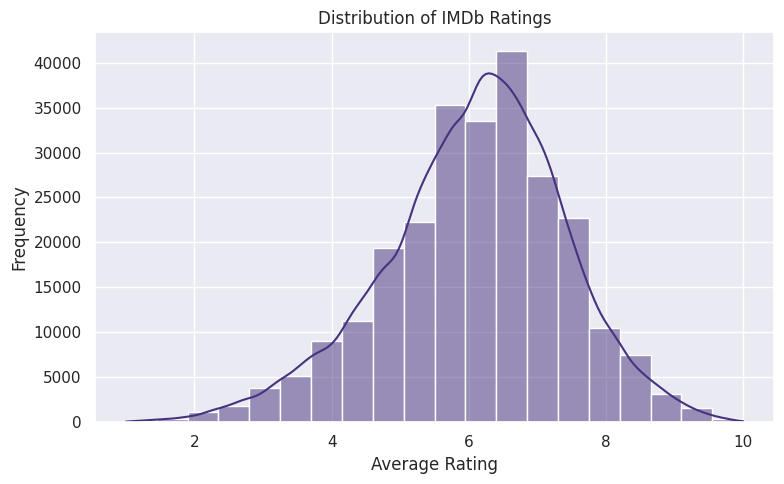

In [ ]:
df_pd = df.select("averageRating").dropna().toPandas()

# Plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_pd["averageRating"], bins=20, kde=True)
plt.title("Distribution of IMDb Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The distribution of IMDb average ratings appears approximately bell-shaped, resembling a normal distribution with slight right skewness. Most ratings cluster between 4.5 and 7.5, with a clear peak around 6.5.Ratings above 8.5 are much less common.

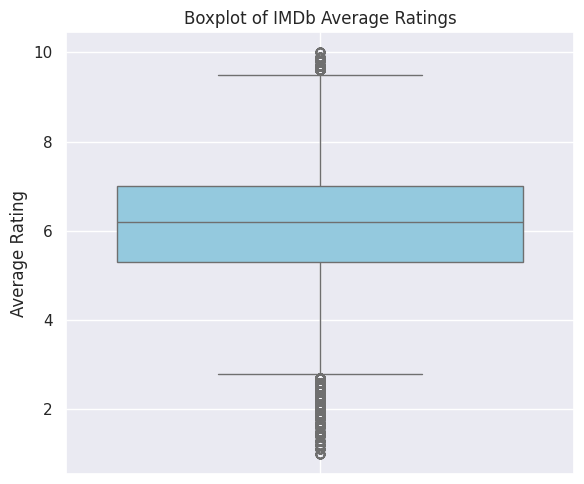

In [ ]:
#Boxplot of Average Ratings
plt.figure(figsize=(6, 5))
sns.boxplot(y="averageRating", data=df_pd, color="skyblue")
plt.title("Boxplot of IMDb Average Ratings")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

The median rating is approximately 6.2, meaning half of the movies score below this and half above. This is consistent with IMDb’s central tendency around 6-7. The box spans from ~5.3 to ~7.2, representing the middle 50% of movies. This indicates that the majority of titles are rated between 5 and 7 — a moderately narrow spread. The plot is slightly left-skewed. There's a longer tail and more outliers on the lower end, suggesting more variability among poorly rated films. Highly rated films are rarer and more consistent.

#### Number of Votes

In [ ]:
df.select("numVotes").describe().show()

+-------+------------------+
|summary|          numVotes|
+-------+------------------+
|  count|            257776|
|   mean| 4586.436258612129|
| stddev|41404.905957672745|
|    min|                 5|
|    max|           3028930|
+-------+------------------+



Applying log10 scaling due to highly skewed data.

<Figure size 800x400 with 0 Axes>

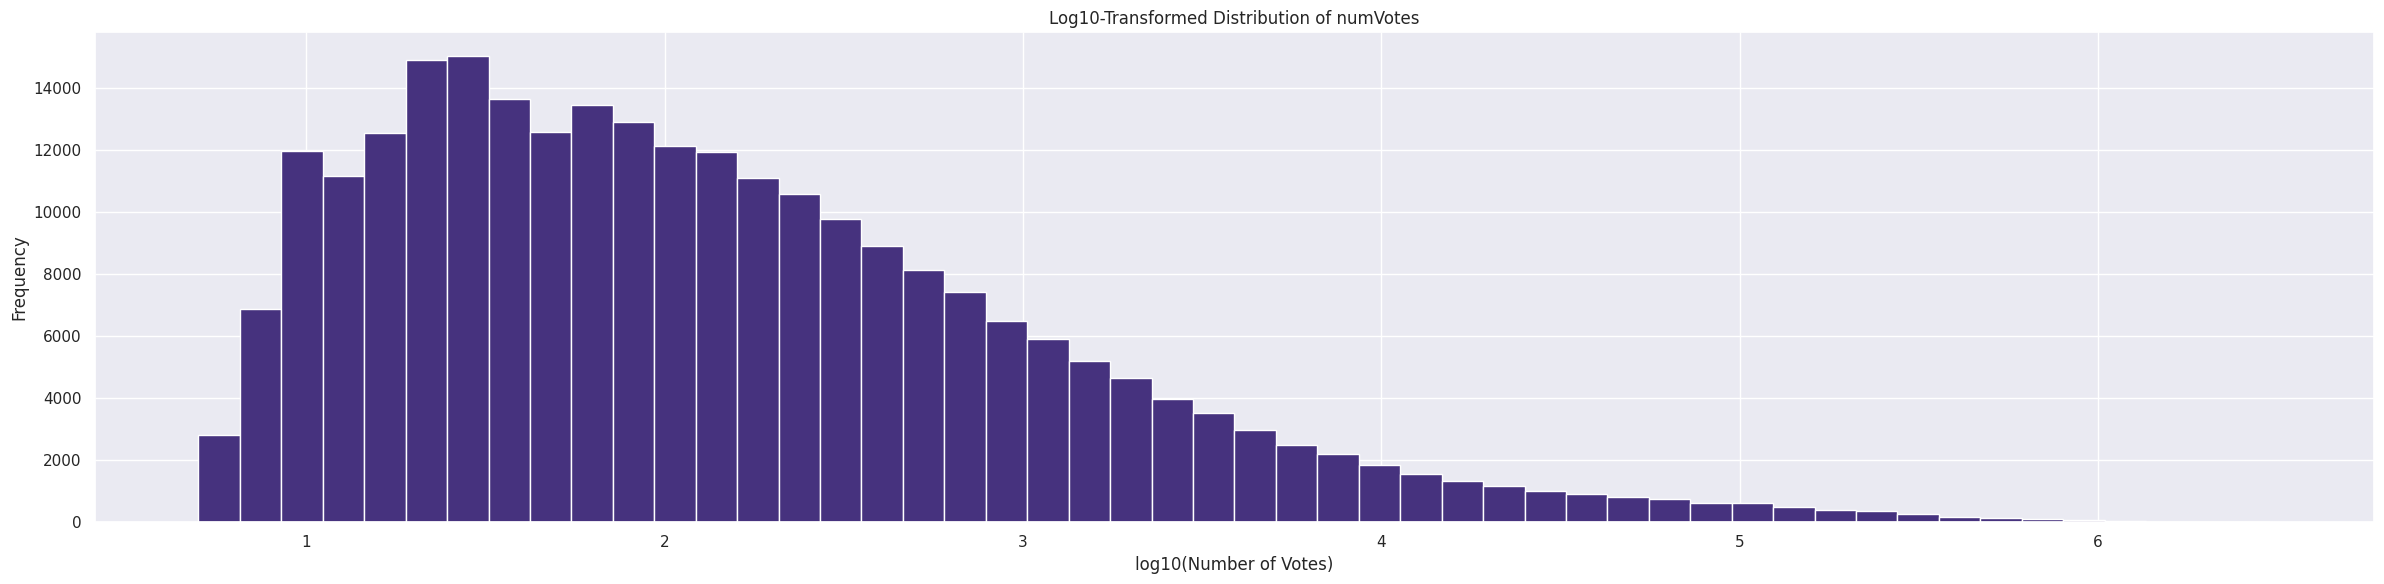

In [ ]:
df_pd = df.select("numVotes").dropna().toPandas()

# Apply log10 transformation
log_votes = np.log10(df_pd)

# Plot
plt.figure(figsize=(8, 4))
log_votes.hist(bins=50)
plt.title("Log10-Transformed Distribution of numVotes")
plt.xlabel("log10(Number of Votes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Most movies fall between 10 and 1,000 votes. The peak is around log10 ≈ 1.3-1.5, meaning ~20-30 votes. This suggests the majority of titles are not widely voted. As the log value increases, frequency steadily drops. A few titles receive 100,000+ votes (log10 > 5), but they are extremely rare. This is a typical right-skewed (long tail) distribution — common in online engagement data.

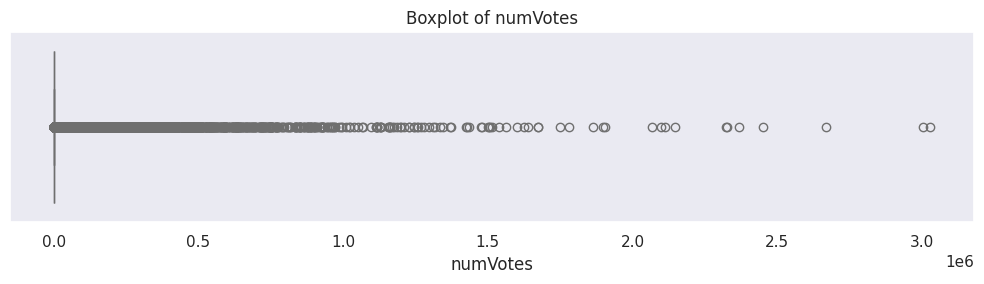

In [ ]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=df_pd["numVotes"], color="skyblue")
plt.title("Boxplot of numVotes")
plt.grid(False)
plt.tight_layout()
plt.show()

So again we observe that "numVotes" variable is heavily skewed and has many extreme outliers.

#### Runtime Minutes

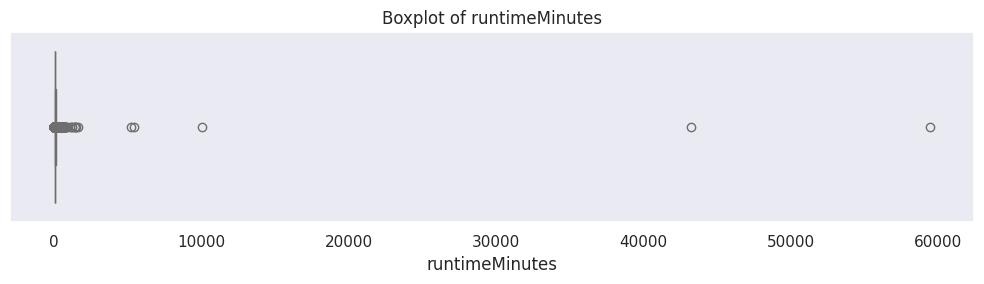

In [ ]:
df_pd = df.select("runtimeMinutes").dropna().toPandas()
plt.figure(figsize=(10, 3))
sns.boxplot(x=df_pd["runtimeMinutes"], color="violet")
plt.title("Boxplot of runtimeMinutes")
plt.grid(False)
plt.tight_layout()
plt.show()

Most of the data is compressed on the left side, indicating that the majority of films have relatively short durations. A few films have extremely long runtimes (e.g., over 10,000 minutes or even 60,000 minutes), which are likely data entry errors or edge cases (e.g., miniseries or metadata mistakes). The median (center line in the box) appears to be around 90–100 minutes, which is a typical feature-length film duration. Many runtimes over 500 minutes (8+ hours) are shown.

In [ ]:
# Drop movies over 600 minutes
df = df[df["runtimeMinutes"] <= 600]

We're removing extremely long or unrealistic movie duration and set a threshold of 600 minutes ,basically 10 hours.

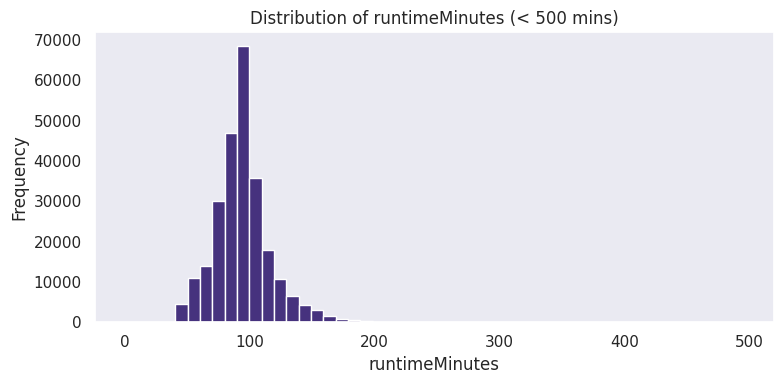

In [ ]:
# Filter data to zoom in (e.g., exclude outliers > 500 mins)
df_filtered = df_pd[df_pd["runtimeMinutes"] < 500]

# Plot
plt.figure(figsize=(8, 4))
df_filtered["runtimeMinutes"].hist(bins=50)
plt.title("Distribution of runtimeMinutes (< 500 mins)")
plt.xlabel("runtimeMinutes")
plt.ylabel("Frequency")
plt.grid(False)
plt.tight_layout()
plt.show()

The peak (mode) of the distribution is around 100 minutes, which is typical for standard feature films. This suggests that most movies in the dataset are conventional full-length films. There's a smaller frequency of very short films (under 60 minutes), including short films, TV episodes, or experimental works.Very few titles exceed 180 minutes (3 hours). The distribution is positively skewed.

### Categorical Variables

#### isAdult

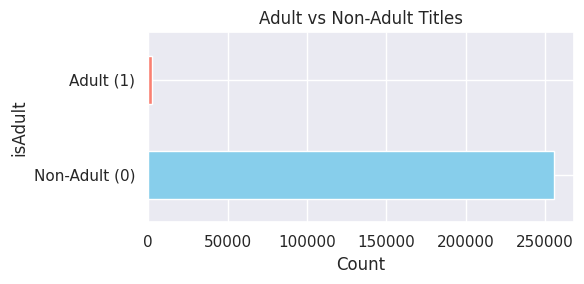

In [ ]:
# Convert only the 'isAdult' column to Pandas
df_pd = df.select("isAdult").dropna().toPandas()

# Plot horizontal bar chart
plt.figure(figsize=(6, 3))
df_pd['isAdult'].value_counts().sort_index().plot(kind='barh', color=["skyblue", "salmon"])
plt.xlabel("Count")
plt.title("Adult vs Non-Adult Titles")
plt.yticks([0, 1], ['Non-Adult (0)', 'Adult (1)'])
plt.tight_layout()
plt.show()

The bar for Non-Adult (0) is extremely long, representing over 250,000 titles.These are regular films, TV shows, documentaries, etc. The bar for Adult (1) is barely visible.As calculated earlier from the .describe() output, adult titles make up less than 1% of the dataset (mean ≈ 0.009). This highlights a strong class imbalance.

#### Start Year

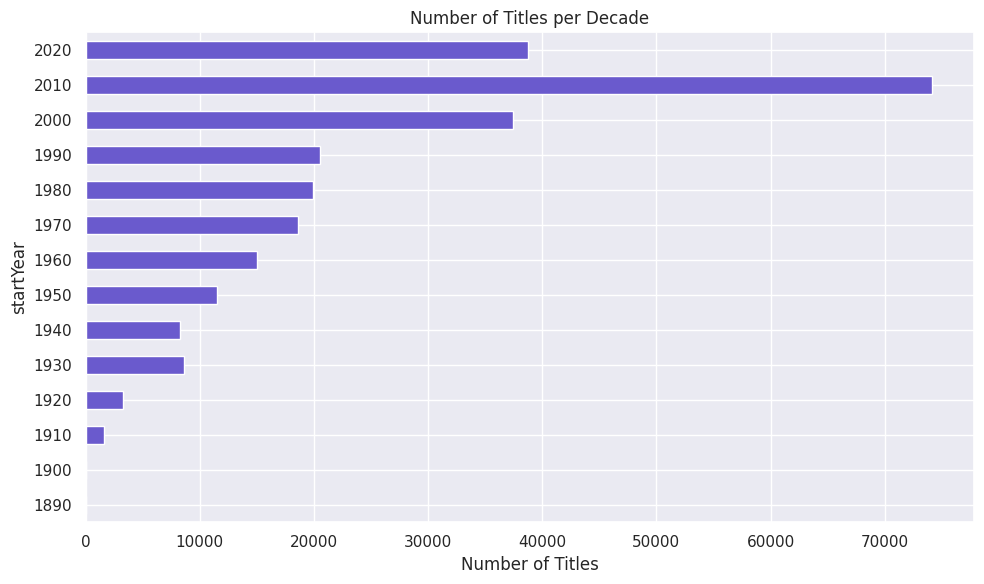

In [ ]:
# Convert 'startYear' to Pandas Series and calculate decades
start_decades = df.select("startYear").dropna().toPandas()
start_decades = (start_decades["startYear"] // 10) * 10

# Plot the number of titles per decade
plt.figure(figsize=(10, 6))
start_decades.value_counts().sort_index().plot(kind='barh', color="slateblue")
plt.xlabel("Number of Titles")
plt.title("Number of Titles per Decade")
plt.tight_layout()
plt.show()

The 2010s stand out as the decade with the highest number of titles, exceeding 70,000. This likely reflects the digital revolution, where lower production costs and streaming platforms (e.g., Netflix, YouTube, Amazon Prime) significantly increased content creation. From the early 1900s to the 1950s, the number of produced titles per decade gradually increases. After the 1950s, there is a notable acceleration, especially from the 1980s onward. The 2020s show slightly fewer titles than the 2010s. This may be due to the COVID-19 pandemic, which disrupted production globally.

#### Role categories

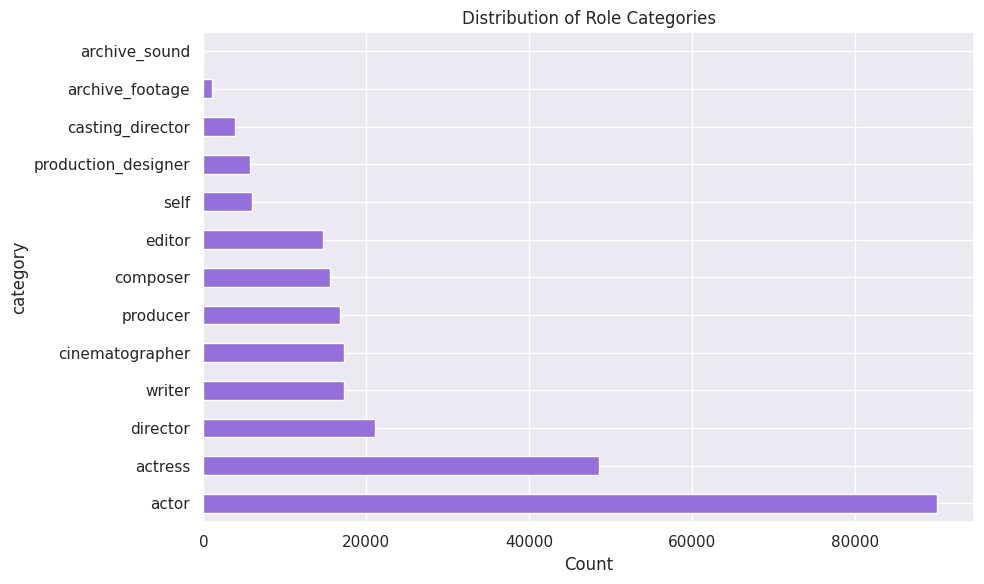

In [ ]:
df_pd = df.select("category").toPandas()

plt.figure(figsize=(10, 6))
df_pd["category"].value_counts().plot(kind='barh', color='mediumpurple')
plt.xlabel("Count")
plt.title("Distribution of Role Categories")
plt.tight_layout()
plt.show()

Actor is by far the most frequent role category, followed by Actress. Together, they significantly outnumber all other categories. This suggests a strong emphasis on acting roles within the dataset, which is expected in a movie-oriented database like IMDb. Roles such as Director, Writer, Cinematographer, Producer, and Composer appear in relatively similar and moderate frequencies. Archive_sound, Archive_footage, Casting_director, and Production_designer are the least common.

#### Primary Professions

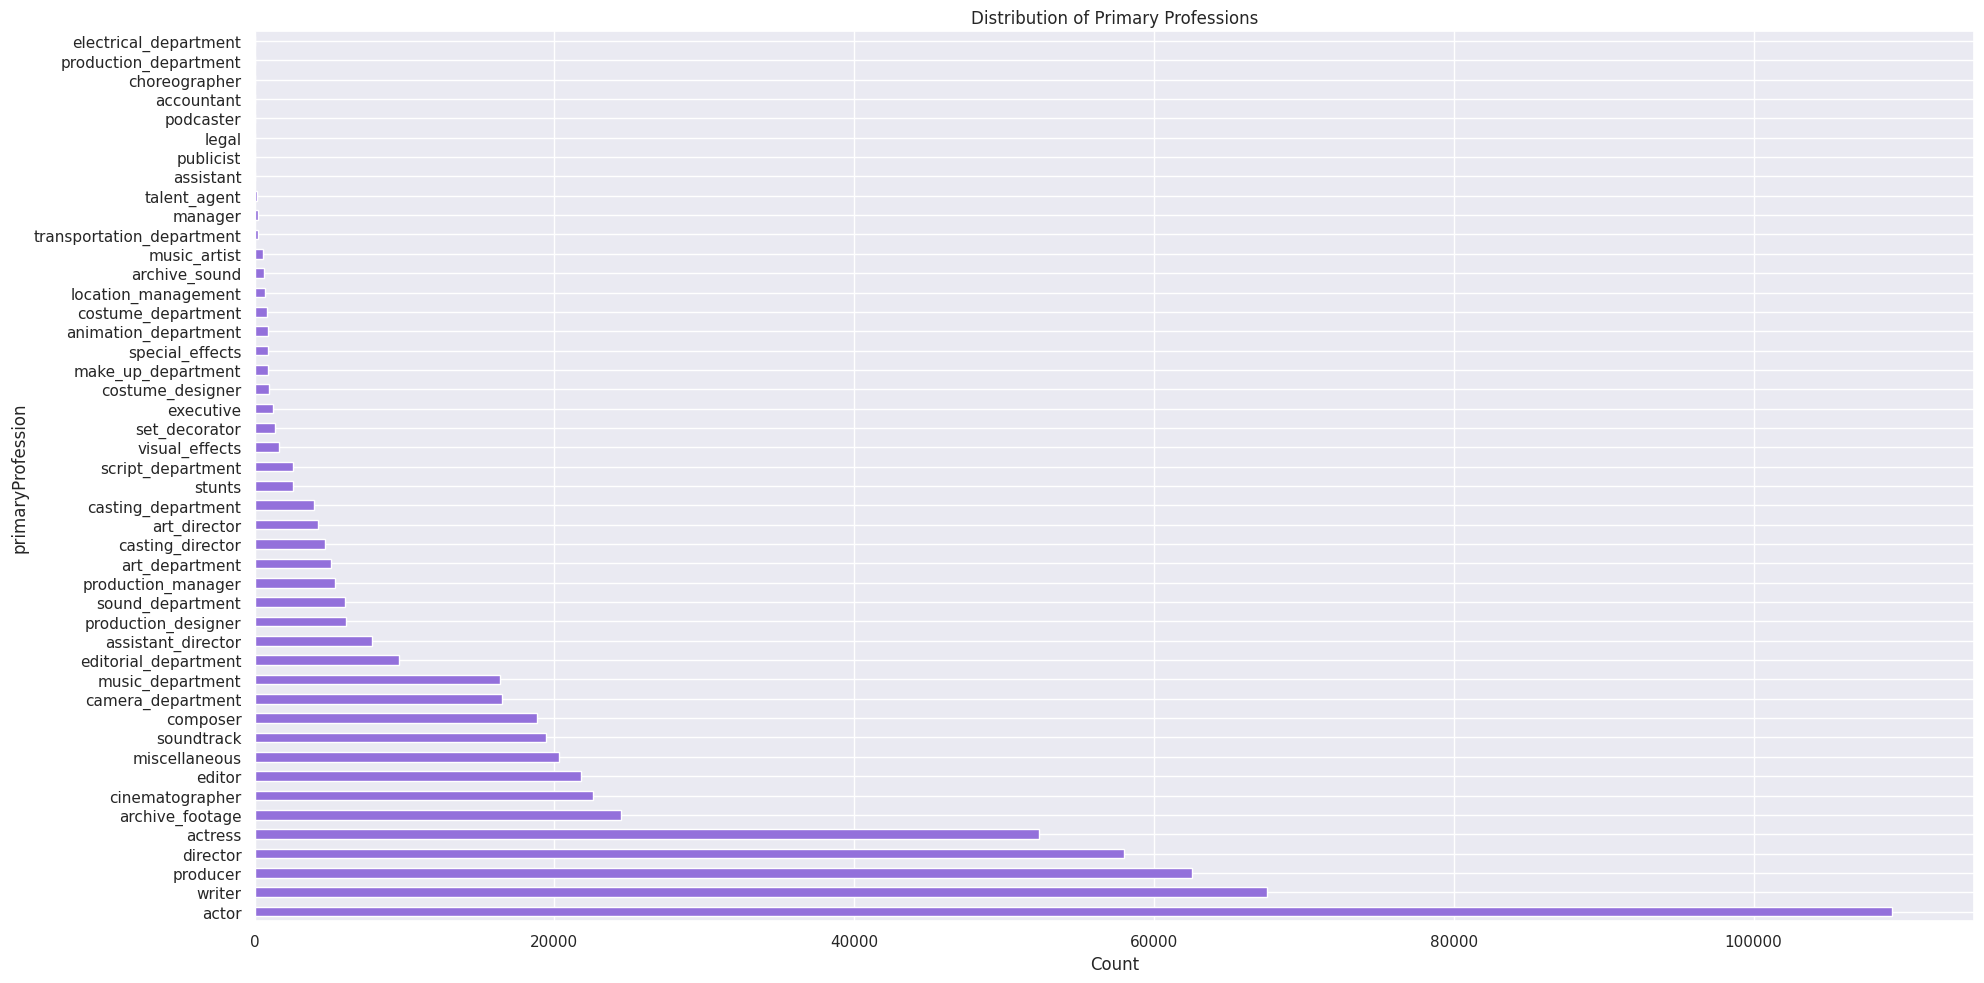

In [ ]:
# Convert Spark DataFrame to pandas
df_pd = df.select("primaryProfession").dropna().toPandas()

# Split and explode the comma-separated values
prof_series = df_pd["primaryProfession"].str.split(',').explode()

# Now plot
plt.figure(figsize=(20, 10))
prof_series.value_counts().plot(kind='barh', color="mediumpurple")
plt.xlabel("Count")
plt.title("Distribution of Primary Professions")
plt.tight_layout()
plt.show()

"actor" dominates as the most frequent primary profession, with over 100,000 entries followed by: writer,producer,director,actress. The gap between actor and actress is quite noticeable, suggesting more male-identified individuals are listed in acting roles. Roles like cinematographer, editor, composer, and soundtrack show moderate representation. Categories such as legal, publicist, manager, talent_agent, and archive_sound are extremely rare, indicating niche or backend roles not frequently listed in the dataset.

#### Primary Name

<Figure size 1000x800 with 0 Axes>

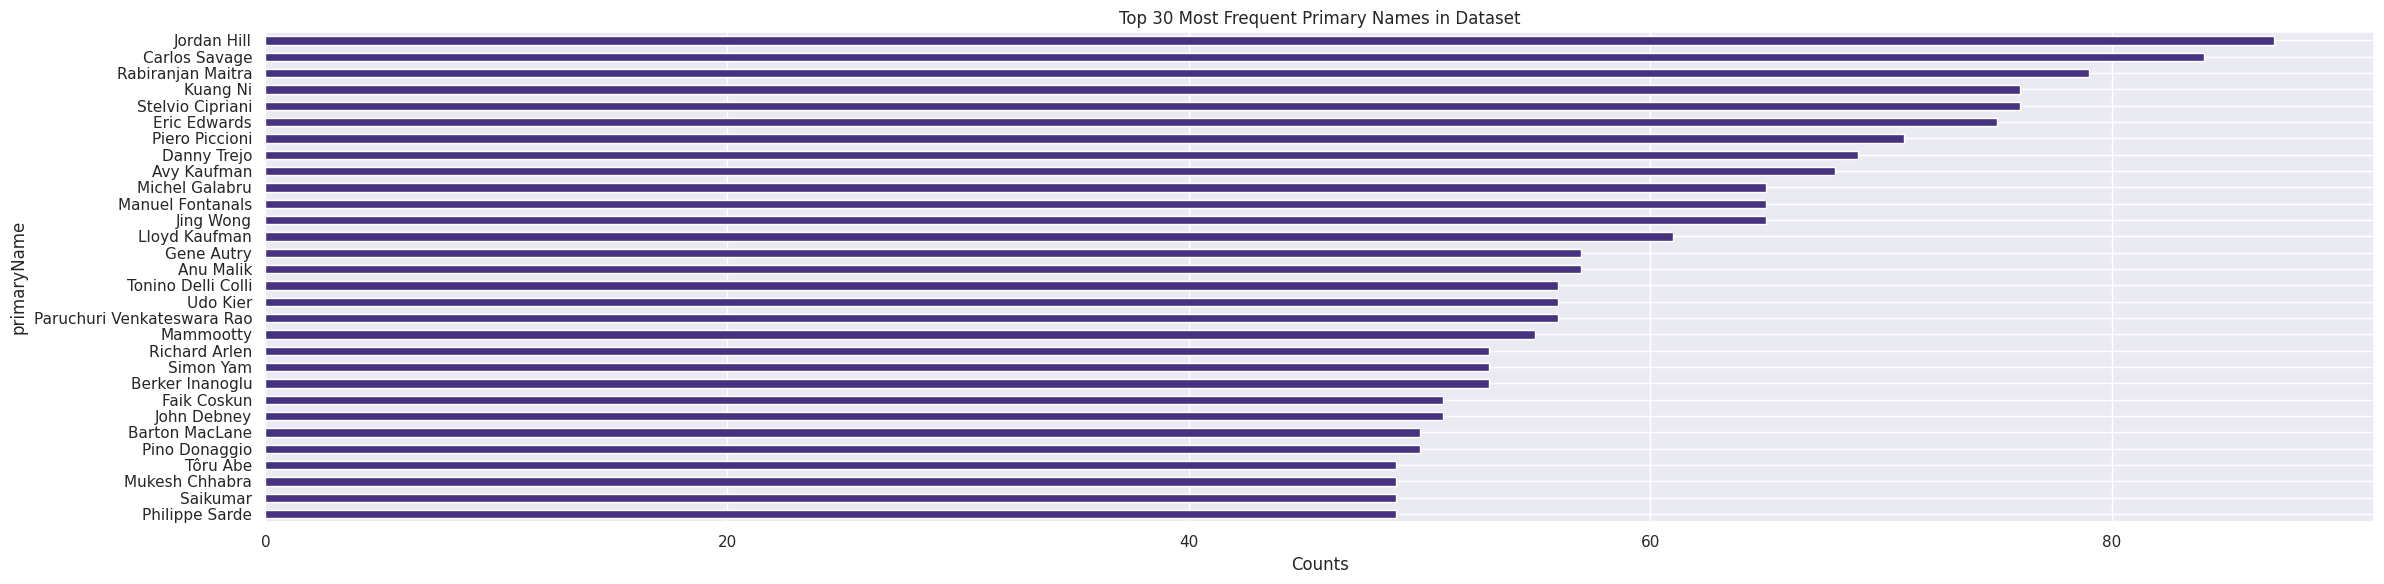

In [ ]:
#Count occurrences
top_names_df = df.groupBy("primaryName").count().orderBy("count", ascending=False).limit(30)

#Convert to Pandas for plotting
top_names_pd = top_names_df.toPandas().set_index("primaryName")

#Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
top_names_pd.sort_values("count").plot(kind='barh', legend=False)
plt.xlabel("Counts")
plt.title("Top 30 Most Frequent Primary Names in Dataset")
plt.tight_layout()
plt.show()

#### Genres

In [ ]:
from pyspark.sql.functions import split, explode

# Explode genres and count occurrences
genre_counts = df.withColumn("genre", explode(split("genres", ","))) \
                        .groupBy("genre") \
                        .count() \
                        .orderBy("count", ascending=False)

genre_counts.show()

+-----------+------+
|      genre| count|
+-----------+------+
|      Drama|128996|
|     Comedy| 70263|
|    Romance| 31556|
|Documentary| 30877|
|     Action| 27948|
|      Crime| 25696|
|   Thriller| 24592|
|     Horror| 21844|
|  Adventure| 17486|
|    Mystery| 11984|
|     Family| 10696|
|    Fantasy|  8770|
|  Biography|  8054|
|    History|  7603|
|     Sci-Fi|  7014|
|      Music|  5846|
|    Musical|  5833|
|        War|  5808|
|    Western|  5169|
|  Animation|  4870|
+-----------+------+
only showing top 20 rows



In [ ]:
unique_genres = df.withColumn("genre", explode(split("genres", ","))) \
                         .select("genre") \
                         .distinct() \
                         .count()

print(f"Number of unique genres: {unique_genres}")

Number of unique genres: 27


<ipython-input-40-a9082211e4c2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="genre", x="count", data=genre_counts_pd.head(20), palette="flare")


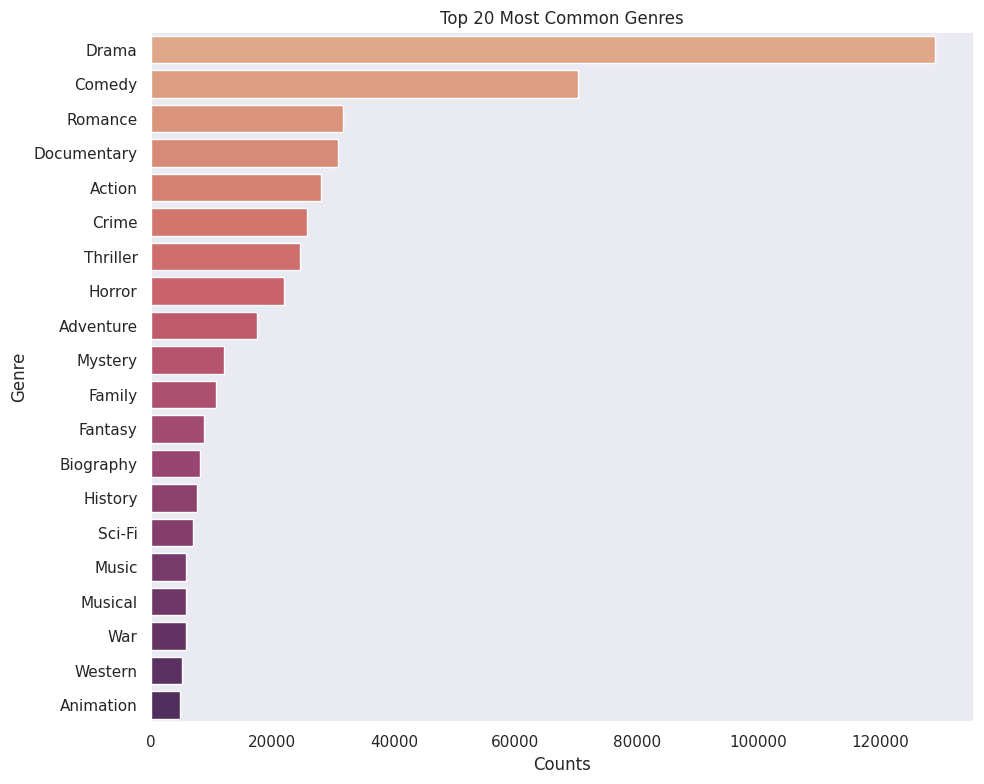

In [ ]:
# Convert genre_counts  to pandas
genre_counts_pd = genre_counts.toPandas()

# Plot vertically
plt.figure(figsize=(10, 8))
sns.barplot(y="genre", x="count", data=genre_counts_pd.head(20), palette="flare")
plt.title("Top 20 Most Common Genres")
plt.xlabel("Counts")
plt.ylabel("Genre")
plt.grid(False)
plt.tight_layout()
plt.show()

Drama is by far the most frequent genre, with well over 120,000 titles. Comedy follows with a strong presence, reaching approximately 65,000 titles.
Romance and Documentary are the next most common, each around 30,000–40,000 titles. Genres like Action, Crime, Thriller, and Horror follow closely, all between 20,000–30,000 titles. Animation, Western, and War are the least represented in the top 20, each with fewer than 10,000 entries.

#### Writers

In [ ]:
top_writers = df.groupBy("writers") \
                       .count() \
                       .orderBy("count", ascending=False) \
                       .limit(10)

top_writers.show()

+---------+-----+
|  writers|count|
+---------+-----+
|nm0960106|  195|
|nm0876561|  162|
|nm0939147|  138|
|nm0649320|  111|
|nm0781261|  104|
|nm0000636|   95|
|nm0393250|   91|
|nm1802130|   77|
|nm0784149|   68|
|nm0765430|   60|
+---------+-----+



<ipython-input-42-7c2da27bd50a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="writers", x="count", data=top_writers_pd, palette="rocket")


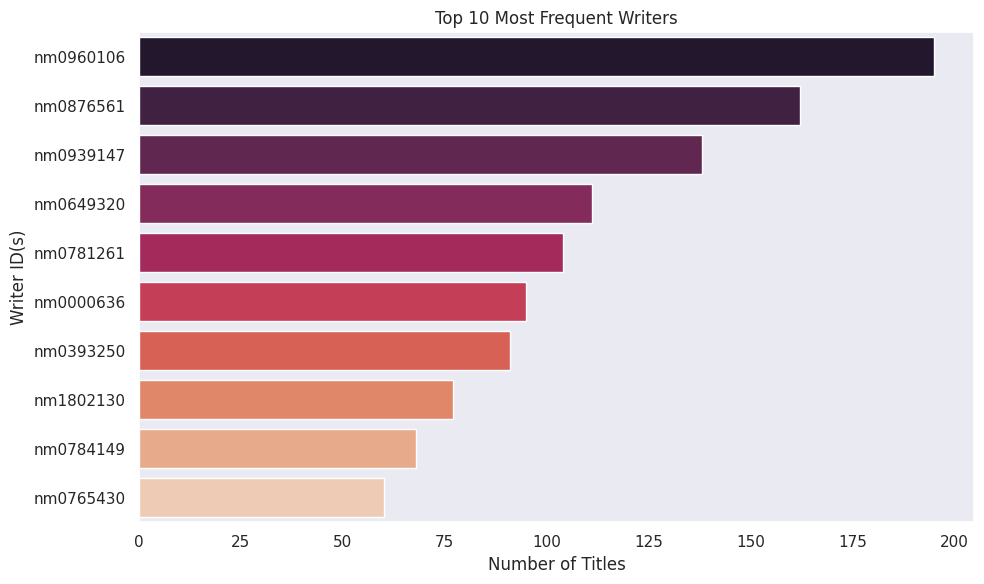

In [ ]:
# Convert to Pandas
top_writers_pd = top_writers.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(y="writers", x="count", data=top_writers_pd, palette="rocket")
plt.title("Top 10 Most Frequent Writers")
plt.xlabel("Number of Titles")
plt.ylabel("Writer ID(s)")
plt.grid(False)
plt.tight_layout()
plt.show()

+--------------------+-----+
|         primaryName|count|
+--------------------+-----+
|            Kuang Ni|   74|
|Paruchuri Venkate...|   45|
|       Anton Chekhov|   36|
|         BC Fourteen|   36|
|      Lillie Hayward|   35|
|        Arthur Hoerl|   34|
|          Ramón Obón|   30|
|   Dardano Sacchetti|   30|
|José María Fernán...|   28|
|         Bülent Oran|   26|
+--------------------+-----+



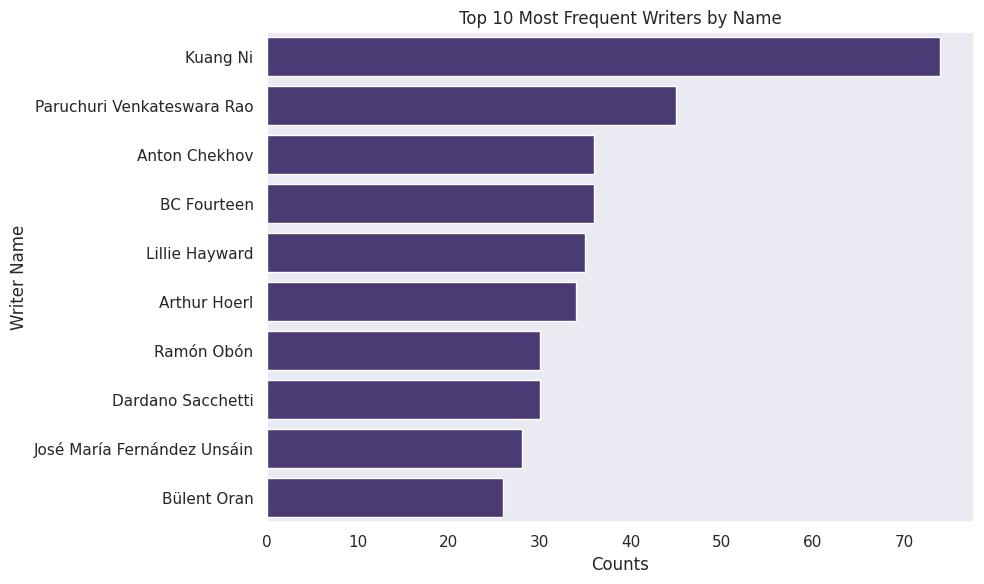

In [ ]:
top_writer_names = df.filter(df["category"] == "writer") \
                            .groupBy("primaryName") \
                            .count() \
                            .orderBy("count", ascending=False) \
                            .limit(10)

top_writer_names.show()

# Convert to Pandas
top_writer_names_pd = top_writer_names.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="primaryName", data=top_writer_names_pd)
plt.title("Top 10 Most Frequent Writers by Name")
plt.xlabel("Counts")
plt.ylabel("Writer Name")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Directors

In [ ]:
top_directors = df.filter(df["category"] == "director") \
                         .groupBy("primaryName") \
                         .count() \
                         .orderBy("count", ascending=False) \
                         .limit(10)

top_directors.show()

+------------------+-----+
|       primaryName|count|
+------------------+-----+
|       Raoul Walsh|   41|
|      Pedro Lazaga|   34|
|       Franz Antel|   34|
|    Osman F. Seden|   29|
|       Orhan Aksoy|   28|
|   Joseph W. Sarno|   27|
|Kostas Karagiannis|   26|
| Alejandro Galindo|   25|
|  D. Ross Lederman|   24|
|          Sam Wood|   24|
+------------------+-----+



<ipython-input-45-68a5163455df>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="primaryName", data=top_directors_pd, palette="crest")


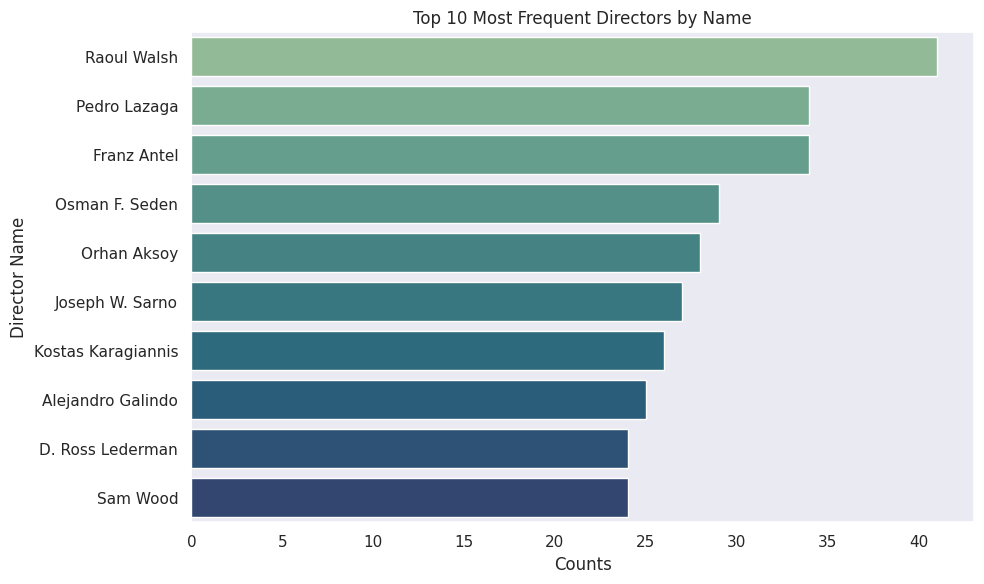

In [ ]:
# Convert to pandas
top_directors_pd = top_directors.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="primaryName", data=top_directors_pd, palette="crest")
plt.title("Top 10 Most Frequent Directors by Name")
plt.xlabel("Counts")
plt.ylabel("Director Name")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Actors

In [ ]:
top_actors = df.filter(
    (df["category"] == "actor") | (df["category"] == "actress")
).groupBy("primaryName") \
 .count() \
 .orderBy("count", ascending=False) \
 .limit(10)

top_actors.show()

+--------------+-----+
|   primaryName|count|
+--------------+-----+
|  Eric Edwards|   71|
|   Danny Trejo|   68|
|Michel Galabru|   65|
|    Gene Autry|   55|
|     Mammootty|   54|
|     Simon Yam|   53|
|      Udo Kier|   53|
| Richard Arlen|   52|
|   Faik Coskun|   51|
|Barton MacLane|   50|
+--------------+-----+



<ipython-input-47-fbb1759a6645>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="primaryName", data=top_actors_pd, palette="flare")


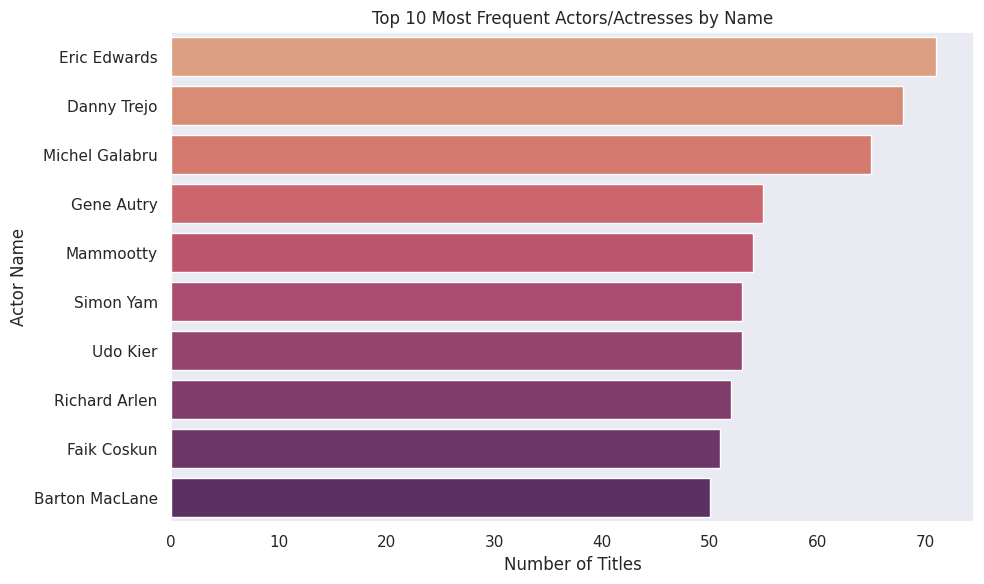

In [ ]:
# Convert to pandas
top_actors_pd = top_actors.toPandas()

# Plot

plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="primaryName", data=top_actors_pd, palette="flare")
plt.title("Top 10 Most Frequent Actors/Actresses by Name")
plt.xlabel("Number of Titles")
plt.ylabel("Actor Name")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Producers

In [ ]:
top_producers = df.filter(df["category"] == "producer") \
                         .groupBy("primaryName") \
                         .count() \
                         .orderBy("count", ascending=False) \
                         .limit(10)

top_producers.show()

+--------------------+-----+
|         primaryName|count|
+--------------------+-----+
|     Berker Inanoglu|   53|
|         Jordan Hill|   46|
|     Fulvio Lucisano|   44|
|Vincent Del Rosar...|   30|
|Vittorio Cecchi Gori|   30|
|     Nicola Giuliano|   26|
|         Fiaz Servia|   25|
| Gregorio Walerstein|   25|
|    Eric Scott Woods|   25|
|       Menahem Golan|   24|
+--------------------+-----+



<ipython-input-49-8f79a00f2a2a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="primaryName", data=top_producers_pd, palette="ch:s=-.2,r=.6")


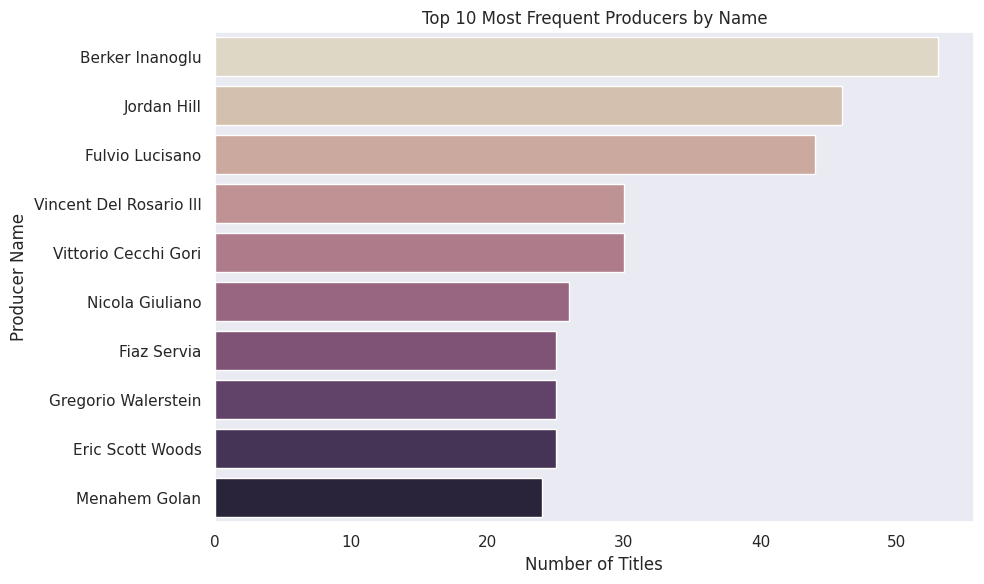

In [ ]:
# Convert to pandas
top_producers_pd = top_producers.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="primaryName", data=top_producers_pd, palette="ch:s=-.2,r=.6")
plt.title("Top 10 Most Frequent Producers by Name")
plt.xlabel("Number of Titles")
plt.ylabel("Producer Name")
plt.grid(False)
plt.tight_layout()
plt.show()

## BIVARIATE ANALYSIS

###Numerical vs Numerical

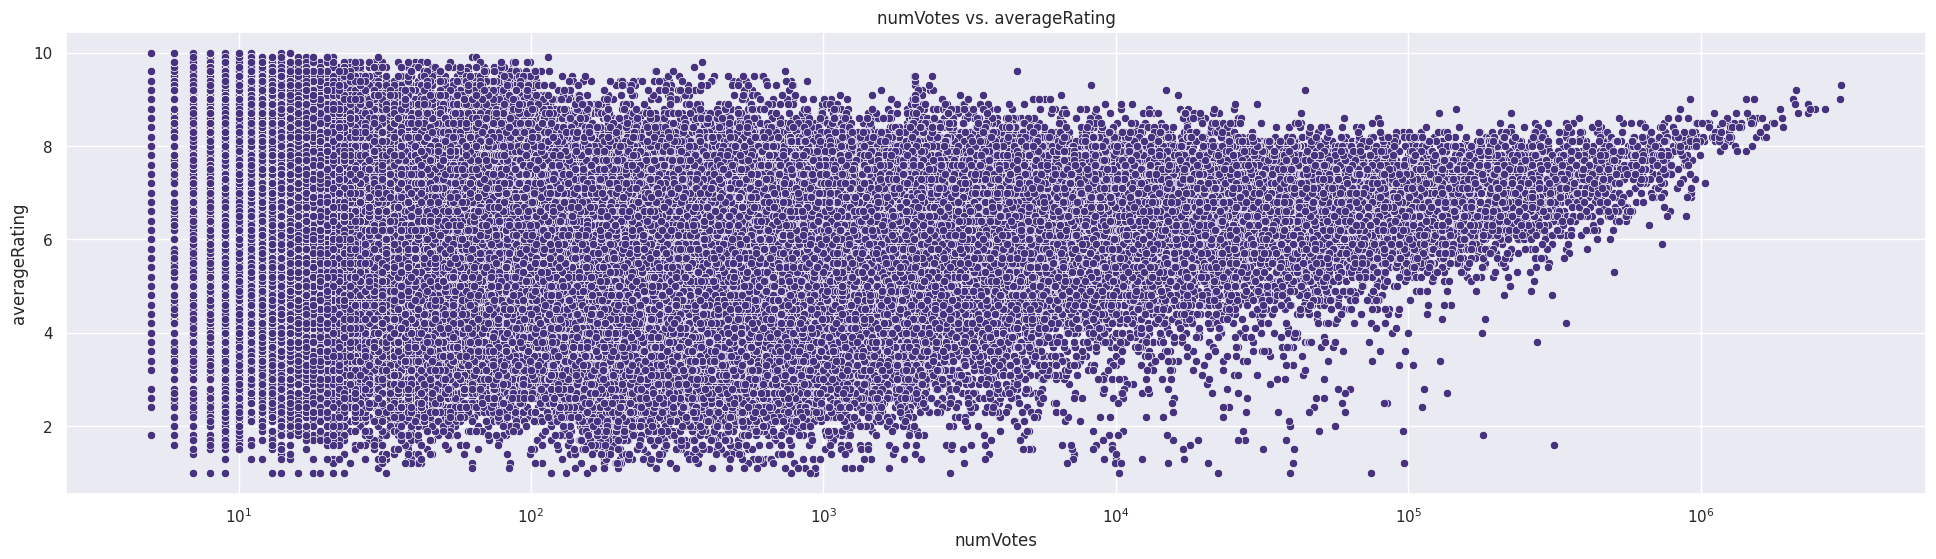

In [ ]:
df_pd = df.select("numVotes", "averageRating").dropna().toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot: numVotes vs. averageRating
sns.scatterplot(x="numVotes", y="averageRating", data=df_pd)
plt.xscale("log")
plt.title("numVotes vs. averageRating")
plt.grid(True)
plt.show()

The plot shows a funnel or triangle pattern, which is typical in voting data.As the number of votes increases, the range of ratings narrows.Titles with very few votes (e.g., <100) have widely scattered ratings from 1 to 10. This indicates high volatility — a few people can heavily influence the average rating. Titles with thousands or millions of votes tend to have ratings clustered around 6-8. These are often popular, mainstream titles with more stable and reliable ratings. There’s a subtle trend: movies with more votes tend to have slightly higher average ratings.

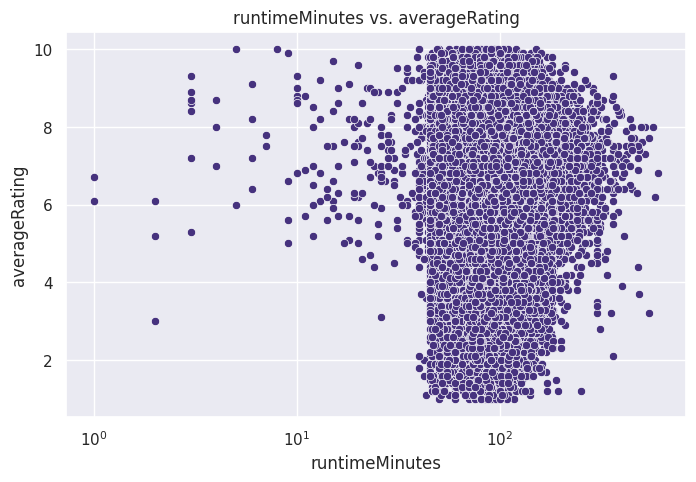

In [ ]:
df_pd = df.select("runtimeMinutes", "averageRating").dropna().toPandas()
plt.figure(figsize=(8, 5))
sns.scatterplot(x="runtimeMinutes", y="averageRating", data=df_pd)
plt.xscale("log")
plt.title("runtimeMinutes vs. averageRating")
plt.grid(True)
plt.show()

The bulk of movies fall in the 10-200 minute range, especially around 90–120 minutes, which aligns with standard film lengths. There are a few short films (under 10 minutes) and very long films (over 300 minutes), but they are rare. Some very short and very long movies received high ratings (8–10), while some were rated very low (~1–3). The scatter cloud doesn’t form a clear trend line, suggesting no strong correlation between runtime and rating.

<ipython-input-52-a183a88af275>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="start_decades", y="averageRating", data=decade_avg, palette="Blues_d")


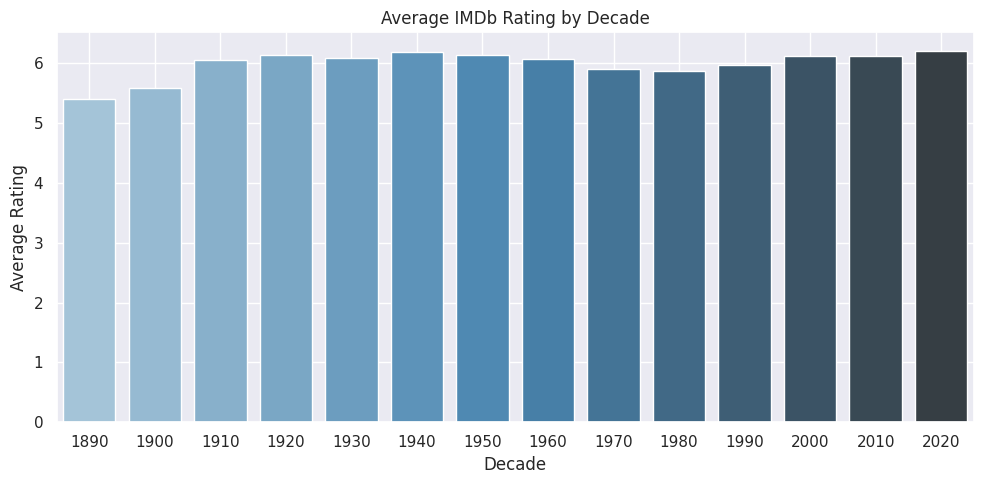

In [ ]:
from pyspark.sql.functions import col, floor

# Create a new column 'start_decades' using PySpark syntax
df = df.withColumn("start_decades", floor(col("startYear") / 10) * 10)
# Group and compute average
decade_avg = df.groupBy("start_decades").avg("averageRating").toPandas()
decade_avg = decade_avg.rename(columns={"avg(averageRating)": "averageRating"})

plt.figure(figsize=(10, 5))
sns.barplot(x="start_decades", y="averageRating", data=decade_avg, palette="Blues_d")
plt.title("Average IMDb Rating by Decade")
plt.xlabel("Decade")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

From the 1890s (avg ≈ 5.4) to the 1940s, there is a clear upward trend in average ratings. The ratings peak around the 1940s–1950s (avg ≈ 6.2). Between the 1950s and 1970s, average ratings remain relatively stable, around 6.1–6.2. The 1980s and 1990s show a minor dip, with ratings falling just below 6.0. The 2020s have the highest average so far, slightly above 6.2. Early low ratings could reflect the limitations of early cinema or fewer total ratings. The 1940s–1950s is often considered a "golden age" of film, which aligns with the rating peak. The recent decades may show higher averages due to more selective user voting, greater fan involvement or the impact of streaming platforms elevating production quality.

<ipython-input-53-9aa179b57d51>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="start_decades", y="runtimeMinutes", data=runtime_by_decade, palette="Greens_d")


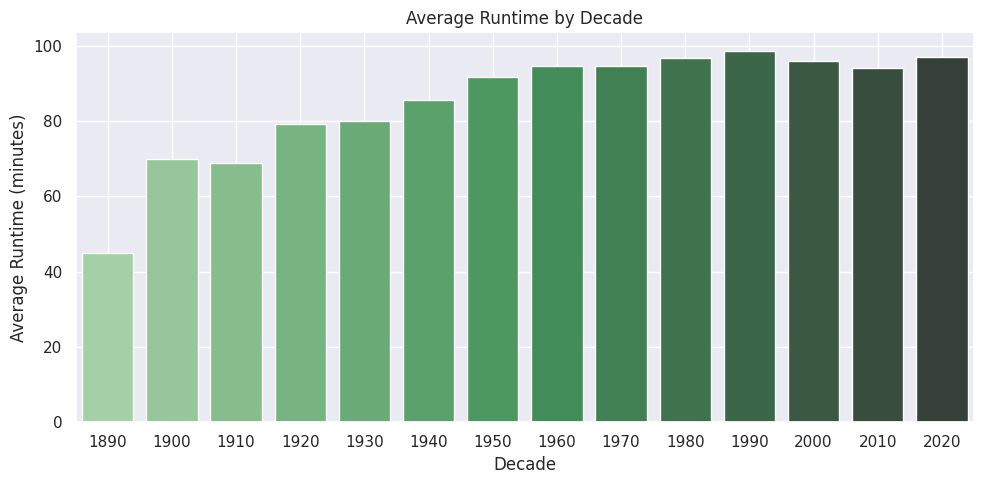

In [ ]:
from pyspark.sql.functions import floor, col

df = df.withColumn("start_decades", floor(col("startYear") / 10) * 10)
runtime_by_decade = df.groupBy("start_decades").agg({"runtimeMinutes": "avg"}).toPandas()
runtime_by_decade.rename(columns={"avg(runtimeMinutes)": "runtimeMinutes"}, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(x="start_decades", y="runtimeMinutes", data=runtime_by_decade, palette="Greens_d")
plt.title("Average Runtime by Decade")
plt.xlabel("Decade")
plt.ylabel("Average Runtime (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

In the 1890s, the average runtime was quite short—around 45 minutes. Runtime steadily increased each decade up to the 1990s, peaking at just under 100 minutes. From the 1980s to the 2020s, runtimes stabilized between 95–98 minutes.
This suggests an industry standard has been reached, possibly based on audience attention span and theater scheduling.Early cinema (1890s–1920s) had much shorter films, which aligns with the limitations of early film technology and the novelty of the medium.

<ipython-input-54-0805a4b73136>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="start_decades", y="numVotes", data=votes_by_decade, palette="Oranges_d")


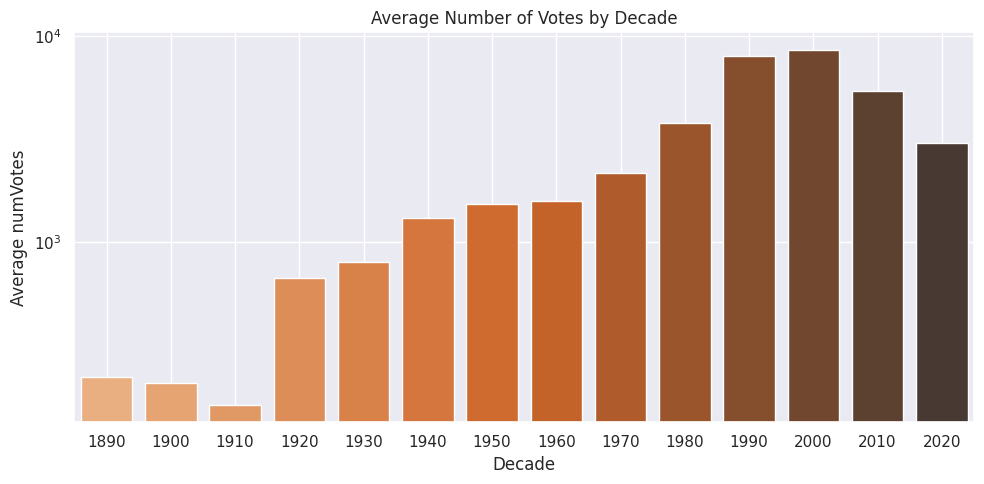

In [ ]:
#Create 'start_decades' column
df = df.withColumn("start_decades", floor(col("startYear") / 10) * 10)

#Group by decade and calculate average numVotes
votes_by_decade = df.groupBy("start_decades").avg("numVotes").withColumnRenamed("avg(numVotes)", "numVotes").toPandas()

#Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="start_decades", y="numVotes", data=votes_by_decade, palette="Oranges_d")
plt.title("Average Number of Votes by Decade")
plt.xlabel("Decade")
plt.ylabel("Average numVotes")
plt.yscale("log")  # Optional: makes skewed values more readable
plt.grid(True)
plt.tight_layout()
plt.show()

The average number of votes per movie increased significantly from 1920 to 2000, peaking in the 2000s.This suggests growing engagement from users in rating films on IMDb, likely due to increased accessibility to internet platforms. The average number of votes dips in the 2010s and drops further in the 2020s.

###Categorical vs Numeric

<ipython-input-55-7f404d921077>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="isAdultLabel", y="averageRating", data=df_pd, palette="pastel")


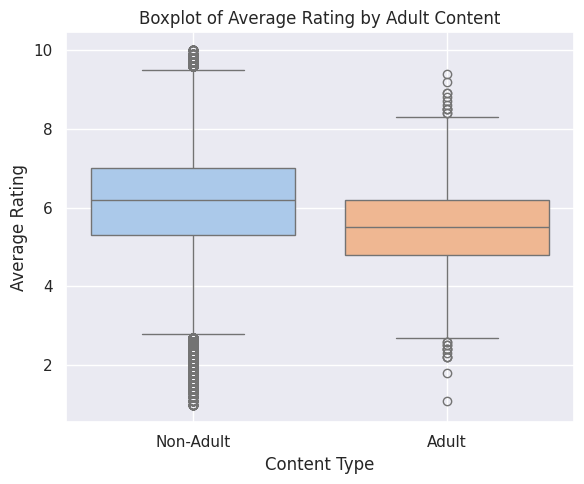

In [ ]:
from pyspark.sql.functions import when

# Create a new column with label
df = df.withColumn("isAdultLabel", when(df["isAdult"] == 1, "Adult").otherwise("Non-Adult"))
# Convert to pandas for plotting
df_pd = df.select("isAdultLabel", "averageRating").dropna().toPandas()

plt.figure(figsize=(6, 5))
sns.boxplot(x="isAdultLabel", y="averageRating", data=df_pd, palette="pastel")
plt.title("Boxplot of Average Rating by Adult Content")
plt.xlabel("Content Type")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

Non-Adult titles have a higher median rating (6.3) than Adult titles (5.8). This suggests that Non-Adult content is generally rated more favorably. Both categories have a similar IQR (the width of the box), indicating similar spread in middle 50% of ratings.
Non-Adult: Wider top quartile — more variation in higher ratings.
Adult: Slightly more compressed around the median.
Both have outliers below and above the whiskers.
Non-Adult shows more high-rating outliers (e.g. ratings ≥ 9).
Adult shows a few more low-rating outliers.

### Correlation Matrix

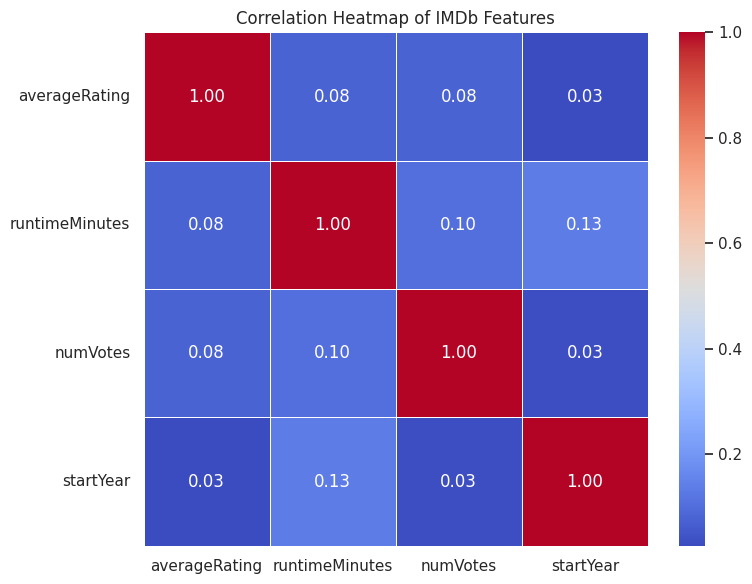

In [ ]:
#List of numerical columns
num_cols = ["averageRating", "runtimeMinutes", "numVotes", "startYear"]

#Convert selected columns to pandas DataFrame
df_pd = df.select(num_cols).toPandas()

#Compute correlation matrix
corr = df_pd.corr()

#Plot heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of IMDb Features")
plt.tight_layout()
plt.show()

There are no strong linear correlations between the selected numerical IMDb features. This suggests that ratings are not directly influenced by runtime, popularity, or release year. Any meaningful relationships may be nonlinear or involve other features (like genre, director, cast, etc.).